Exploring  some of the typical TimeSeries topics such as:

- ACF/PACF
- ARIMA
- Auto-ARIMA
- Prophet
- Augmented Dickey-Fuller (ADF)

In [1]:
# Imprting Libraries
import pandas as pd
import numpy as np # linear algebra
import seaborn as sns # Visualization
import matplotlib.pyplot as plt # Visualization


In [2]:
df = pd.read_csv('Aquifer_Petrignano.csv')
df.head()
df.tail()

,Date,Rainfall_Bastia_Umbra,Depth_to_Groundwater_P24,Depth_to_Groundwater_P25,Temperature_Bastia_Umbra,Temperature_Petrignano,Volume_C10_Petrignano,Hydrometry_Fiume_Chiascio_Petrignano
5218,26/06/2020,0.0,-25.68,-25.07,25.7,24.5,-29930.688,2.5
5219,27/06/2020,0.0,-25.80,-25.11,26.2,25.0,-31332.960,2.4
5220,28/06/2020,0.0,-25.80,-25.19,26.9,25.7,-32120.928,2.4
5221,29/06/2020,0.0,-25.78,-25.18,26.9,26.0,-30602.880,2.4
5222,30/06/2020,0.0,-25.91,-25.25,27.3,26.5,-31878.144,2.4


In [3]:
# Removing old rows
df = df[df.Rainfall_Bastia_Umbra.notna()].reset_index(drop=True)

In [4]:
# Removing not usefull columns
df = df.drop(['Depth_to_Groundwater_P24', 'Temperature_Petrignano'], axis=1)

In [5]:
# Simplify column names
df.columns = ['date', 'rainfall', 'depth_to_groundwater', 'temperature', 'drainage_volume', 'river_hydrometry']

In [6]:
# setting target variable
targets = ['depth_to_groundwater']


In [7]:
features = [feature for feature in df.columns if feature not in targets]


In [8]:
df.head()


,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,01/01/2009,0.0,-31.14,5.2,-24530.688,2.4
1,02/01/2009,0.0,-31.11,2.3,-28785.888,2.5
2,03/01/2009,0.0,-31.07,4.4,-25766.208,2.4
3,04/01/2009,0.0,-31.05,0.8,-27919.296,2.4
4,05/01/2009,0.0,-31.01,-1.9,-29854.656,2.3


Since this is a TimeSeries problem, we have to parse 'date' column

In [9]:
from datetime import datetime, date 
df['date'] = pd.to_datetime(df['date'], format = '%d/%m/%Y')
df.head().style.set_properties(subset=['date'], **{'background-color': 'dodgerblue'})


,date,rainfall,depth_to_groundwater,temperature,drainage_volume,river_hydrometry
0,2009-01-01 00:00:00,0.000000,-31.140000,5.200000,-24530.688000,2.400000
1,2009-01-02 00:00:00,0.000000,-31.110000,2.300000,-28785.888000,2.500000
2,2009-01-03 00:00:00,0.000000,-31.070000,4.400000,-25766.208000,2.400000
3,2009-01-04 00:00:00,0.000000,-31.050000,0.800000,-27919.296000,2.400000
4,2009-01-05 00:00:00,0.000000,-31.010000,-1.900000,-29854.656000,2.300000


## Visualization

- Features:

- Rainfall indicates the quantity of rain falling (mm)
- Temperature indicates the temperature (°C)
- Volume indicates the volume of water taken from the drinking water treatment plant (m 3 )
- Hydrometry indicates the groundwater level (m)
* Target:

- Depth to Groundwater indicates the groundwater level (m from the ground floor)

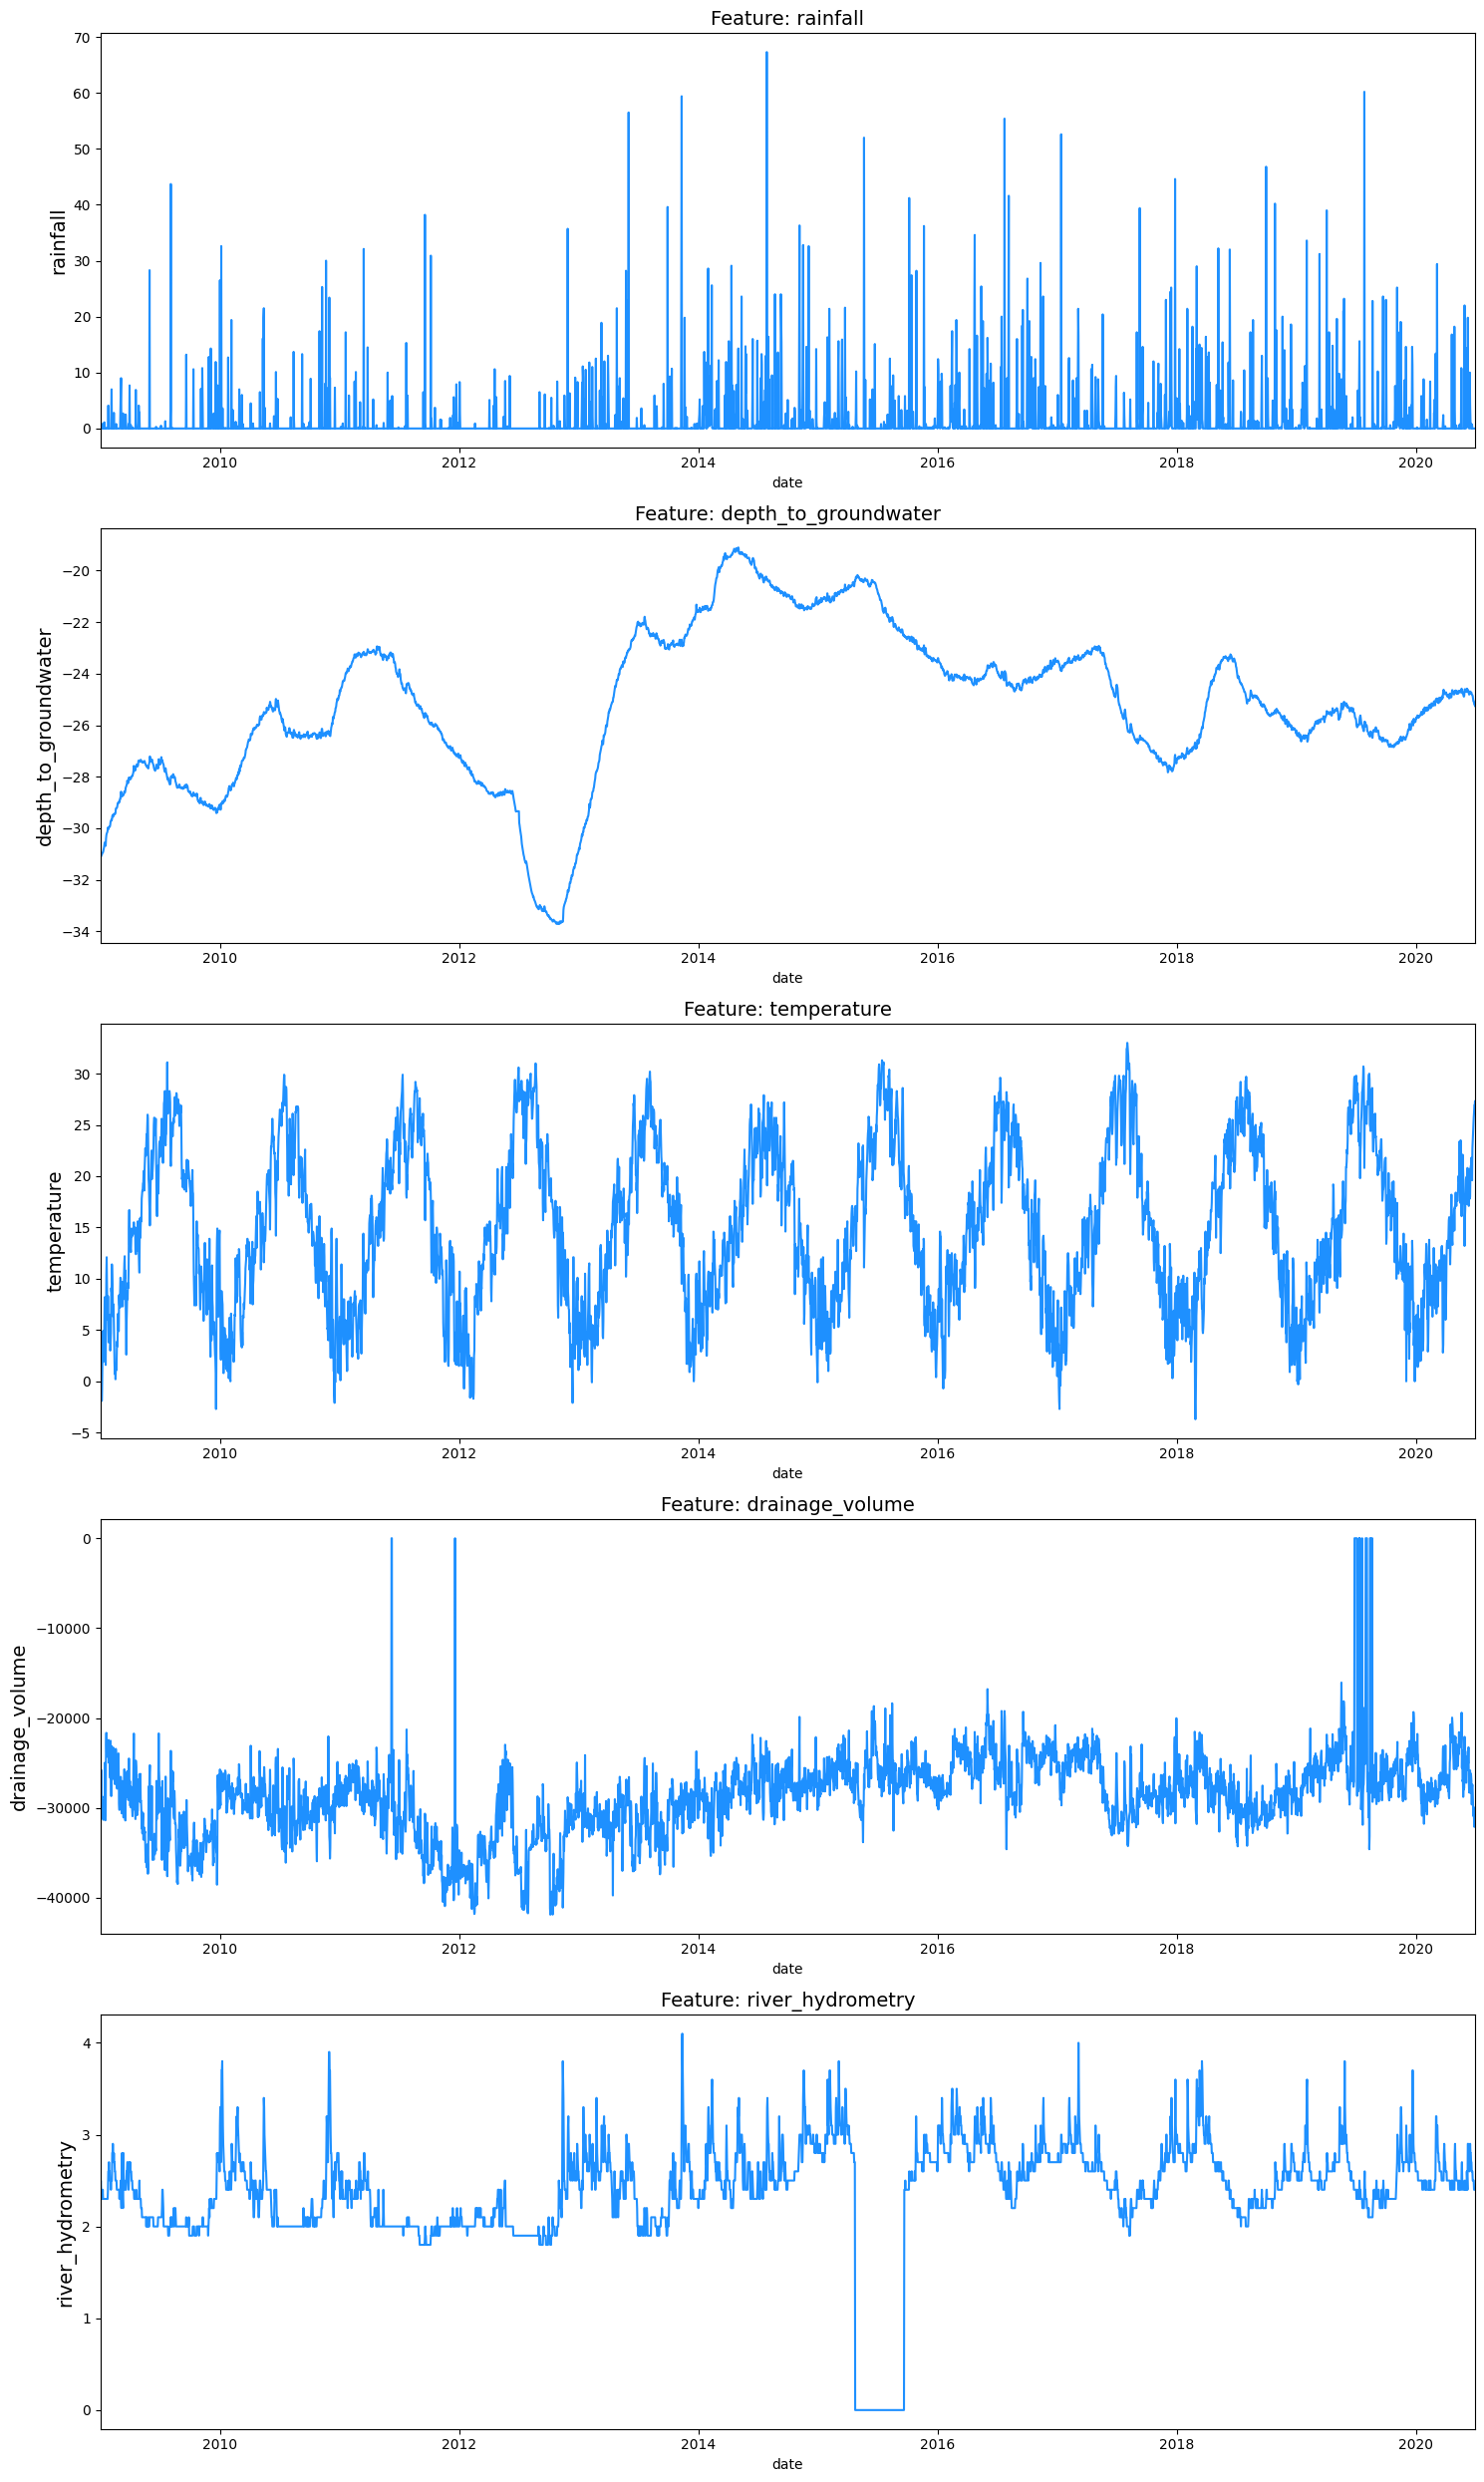

In [10]:
# f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))
# for i, column in enumerate(df.drop('date', axis=1).columns):
#     sns.lineplot(x=df['date'], y=df[column].fillna(method='ffill'), ax=ax[i], color='dodgerblue')
#     ax[i].set_title('Feature: {}'.format(column), fontsize=14)
#     ax[i].set_ylabel(ylabel=column, fontsize=14)
#     ax[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])                


import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create subplots
fig, axes = plt.subplots(nrows=5, ncols=1, figsize=(15, 25))

# Iterate through the first 5 columns
columns_to_plot = df.drop('date', axis=1).columns[:5]
for i, column in enumerate(columns_to_plot):
    # Replace inf values with NaN
    df[column].replace([np.inf, -np.inf], np.nan, inplace=True)
    
    # Forward-fill missing values
    df[column] = df[column].ffill()
    
    # Plot the line plot
    sns.lineplot(x=df['date'], y=df[column], ax=axes[i], color='dodgerblue')
    
    # Set title and labels
    axes[i].set_title('Feature: {}'.format(column), fontsize=14)
    axes[i].set_ylabel(ylabel=column, fontsize=14)
    axes[i].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()




## Data Preprocessing 

## Chronological Order and Equidistant Timestamps

The data should be in chronological order and the timestamps should be equidistant in time series. The chronological order can be achieved by sorting the dataframe by the timestamps. Equidisant timestamps indicates constant time intervals. To check this, the difference between each timestamp can be taken. If this is not the case, you can decide on a constant time interval and resample the data.

But, first of all, lets see how to check if our dataset is correctly formated!

In [11]:
df = df.sort_values(by='date')


# Checking time intervals
df['delta'] = df['date'] - df['date'].shift(1)


df[['date', 'delta']].head()



,date,delta
0,2009-01-01,NaT
1,2009-01-02,1 days
2,2009-01-03,1 days
3,2009-01-04,1 days
4,2009-01-05,1 days


In [12]:
df['delta'].sum(), df['delta'].count()


(Timedelta('4198 days 00:00:00'), 4198)

This is already the case in our data: The time interval is one day and the data is already in chronological order. Therefore, we do not have to do this additional data preparation step.

## Handling the missing data

As we can see, the dataset has some null values.

Furthermore, plotting the time series reveals that there seem to be some zero values that seems to be nulls for drainage_volume, and river_hydrometry. We will have to clean them by replacing them by nan values and filling them afterwards

In [13]:
df = df.drop('delta', axis=1)
df.isna().sum()


date                    0
rainfall                0
depth_to_groundwater    0
temperature             0
drainage_volume         0
river_hydrometry        0
dtype: int64

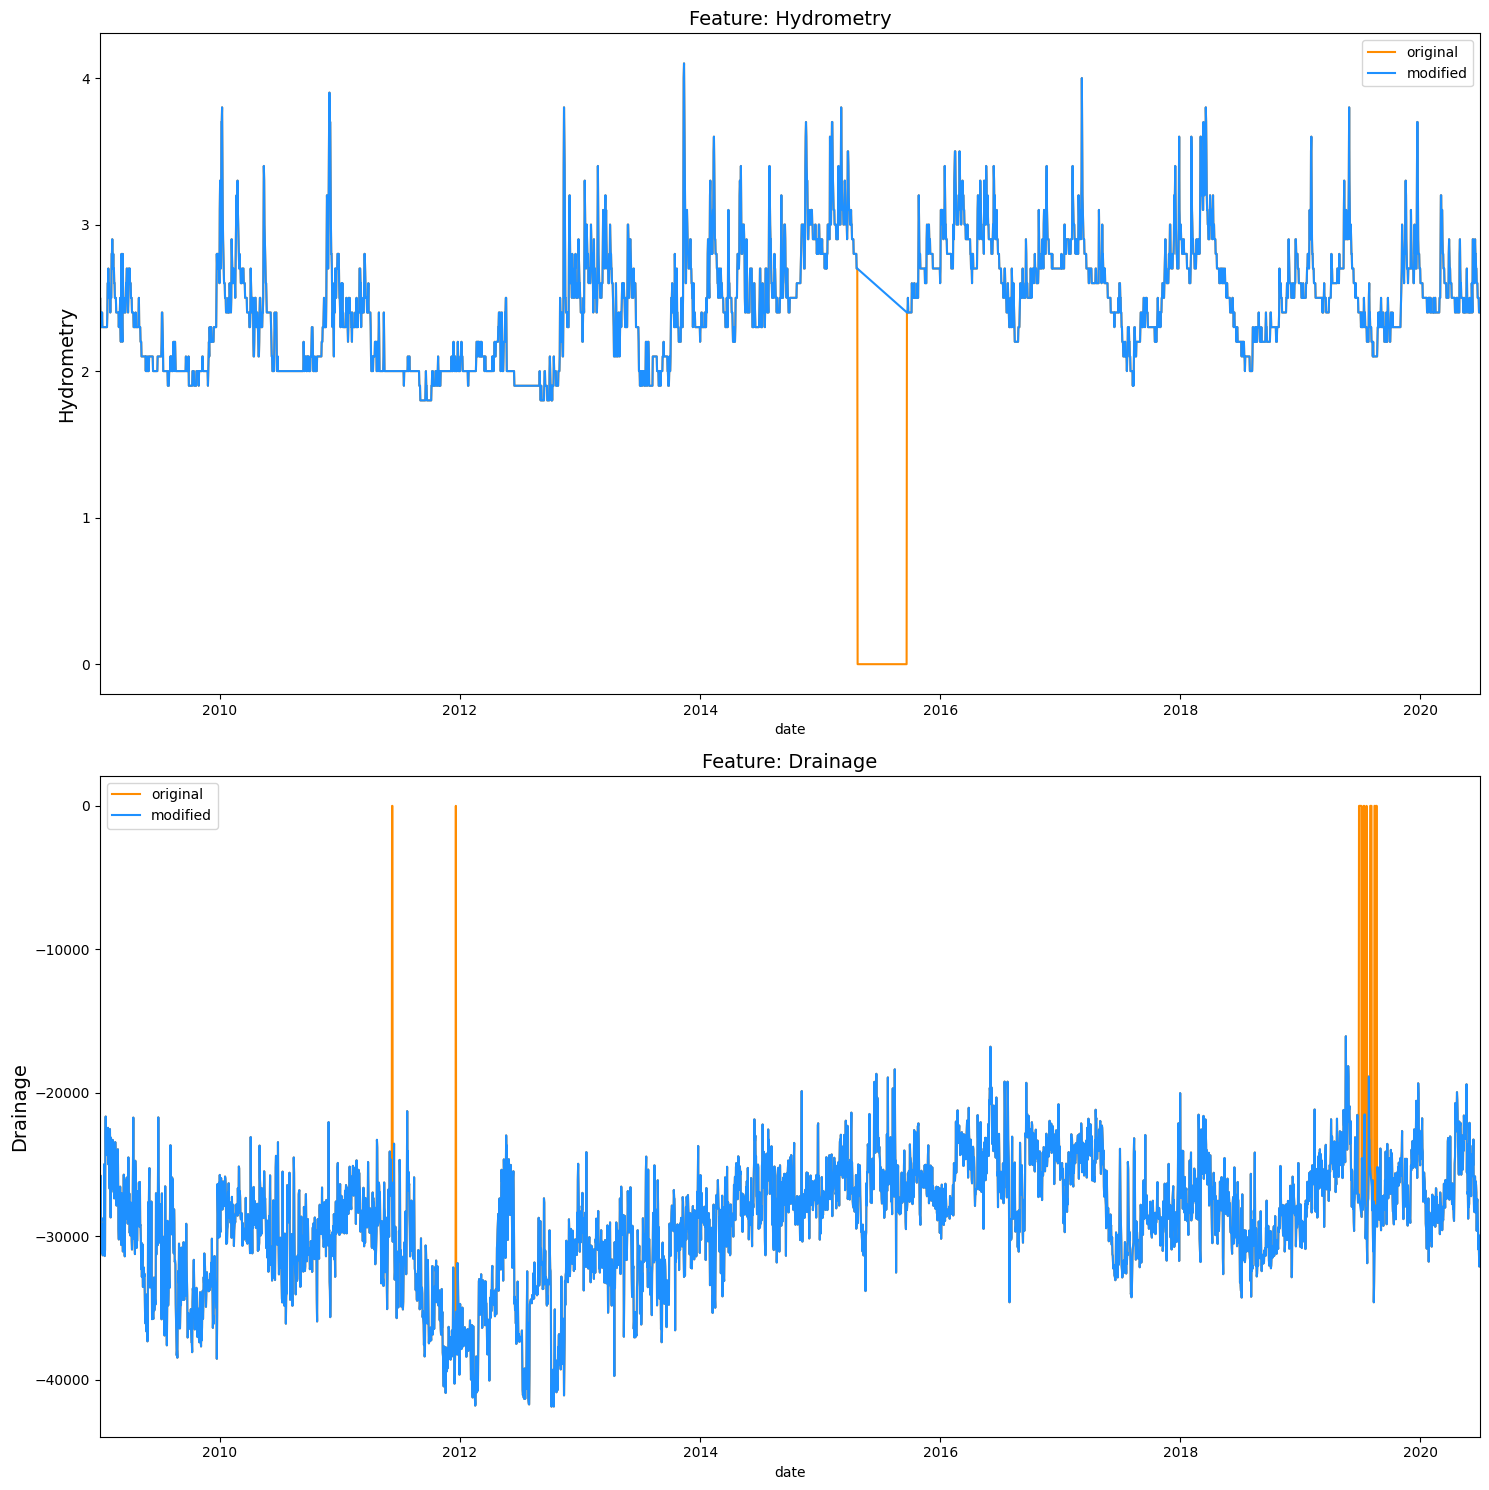

In [14]:
# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# old_hydrometry = df['river_hydrometry'].copy()
# df['river_hydrometry'] = df['river_hydrometry'].replace(0, np.nan)

# sns.lineplot(x=df['date'], y=old_hydrometry, ax=ax[0], color='darkorange', label='original')
# sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
# ax[0].set_title('Feature: Hydrometry', fontsize=14)
# ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
# ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# old_drainage = df['drainage_volume'].copy()
# df['drainage_volume'] = df['drainage_volume'].replace(0, np.nan)

# sns.lineplot(x=df['date'], y=old_drainage, ax=ax[1], color='darkorange', label='original')
# sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
# ax[1].set_title('Feature: Drainage', fontsize=14)
# ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
# ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])


import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import date

# Suppress FutureWarnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Create subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 15))

# Copy the original data for Hydrometry and Drainage
original_hydrometry = df['river_hydrometry'].copy()
original_drainage = df['drainage_volume'].copy()

# Replace 0 values with NaN for Hydrometry and Drainage
df['river_hydrometry'].replace(0, np.nan, inplace=True)
df['drainage_volume'].replace(0, np.nan, inplace=True)

# Plot the original and modified data for Hydrometry
sns.lineplot(x=df['date'], y=original_hydrometry, ax=ax[0], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['river_hydrometry'].fillna(np.inf), ax=ax[0], color='dodgerblue', label='modified')
ax[0].set_title('Feature: Hydrometry', fontsize=14)
ax[0].set_ylabel(ylabel='Hydrometry', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# Plot the original and modified data for Drainage
sns.lineplot(x=df['date'], y=original_drainage, ax=ax[1], color='darkorange', label='original')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label='modified')
ax[1].set_title('Feature: Drainage', fontsize=14)
ax[1].set_ylabel(ylabel='Drainage', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# Adjust spacing between subplots
plt.tight_layout()

# Show the plots
plt.show()



C:\Users\PC\AppData\Local\Temp\ipykernel_26676\1699611792.py:8: MatplotlibDeprecationWarning: The label function was deprecated in Matplotlib 3.1 and will be removed in 3.8. Use Tick.label1 instead.
  tick.label.set_fontsize(14)


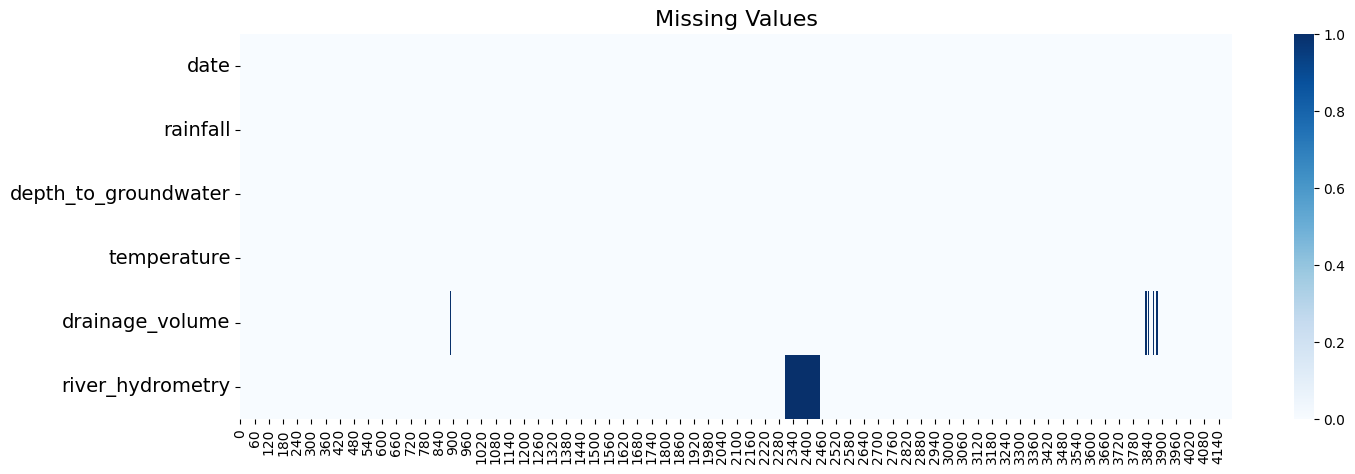

In [15]:


#fixing the missing values
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(16,5))

sns.heatmap(df.T.isna(), cmap='Blues')
ax.set_title('Missing Values', fontsize=16)

for tick in ax.yaxis.get_major_ticks():
    tick.label.set_fontsize(14)
plt.show()






## Missing Values, how to handle
* Option 1: Fill NaN with Outlier or Zero
In this specific example filling the missing value with an outlier value such as np.inf or 0 seems to be very naive. However, using values like -999, is sometimes a good idea.

* Option 2: Fill NaN with Mean Value
Filling NaNs with the mean value is also not sufficient and naive, and doesn't seems to be a good option.

* Option 3: Fill NaN with Last Value with .ffill()
Filling NaNs with the last value could be bit better.

* Option 4: Fill NaN with Linearly Interpolated Value with .interpolate()
Filling NaNs with the interpolated values is the best option in this small examlple but it requires knowledge of the neighouring value

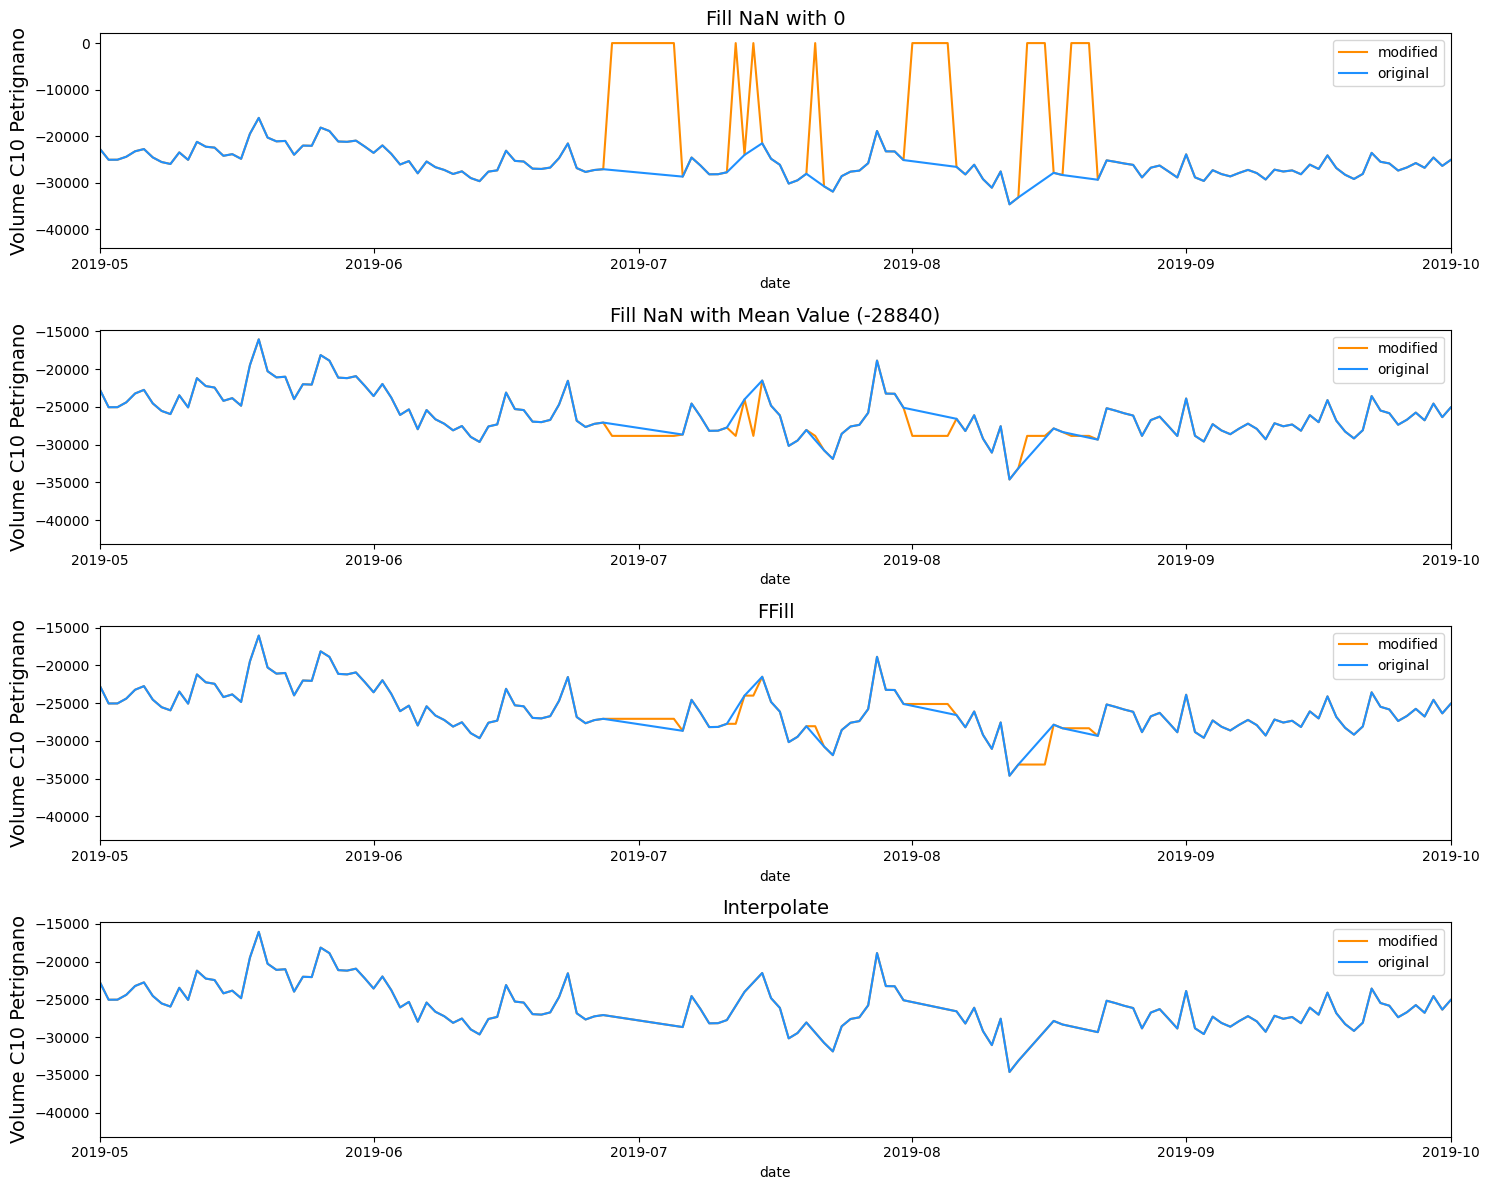

In [16]:
f, ax = plt.subplots(nrows=4, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(0), ax=ax[0], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[0], color='dodgerblue', label = 'original')
ax[0].set_title('Fill NaN with 0', fontsize=14)
ax[0].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)


mean_drainage = df['drainage_volume'].mean()
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(mean_drainage), ax=ax[1], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[1], color='dodgerblue', label = 'original')
ax[1].set_title(f'Fill NaN with Mean Value ({mean_drainage:.0f})', fontsize=14)
ax[1].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)


sns.lineplot(x=df['date'], y=df['drainage_volume'].ffill(), ax=ax[2], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[2], color='dodgerblue', label = 'original')
ax[2].set_title(f'FFill', fontsize=14)
ax[2].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)


sns.lineplot(x=df['date'], y=df['drainage_volume'].interpolate(), ax=ax[3], color='darkorange', label = 'modified')
sns.lineplot(x=df['date'], y=df['drainage_volume'].fillna(np.inf), ax=ax[3], color='dodgerblue', label = 'original')
ax[3].set_title(f'Interpolate', fontsize=14)
ax[3].set_ylabel(ylabel='Volume C10 Petrignano', fontsize=14)



for i in range(4):
    ax[i].set_xlim([date(2019, 5, 1), date(2019, 10, 1)])
plt.tight_layout()
plt.show()

As we can see, the best option in this case, seems to best option!

So, lets interplota missing values

In [17]:
# Interpolating the values
df['drainage_volume'] = df['drainage_volume'].interpolate()
df['river_hydrometry'] = df['river_hydrometry'].interpolate()
df['depth_to_groundwater'] = df['depth_to_groundwater'].interpolate()



## Smoothing Data/ Resampling

* Resampling can provide additional information on the data. There are two types of resampling:

* Upsampling is when the frequency of samples is increased (e.g. days to hours)
* Downsampling is when the frequency of samples is decreased (e.g. days to weeks)

- In this example, we will do some downsampling with the .resample() function (similar to groupby and aggregate as mean).

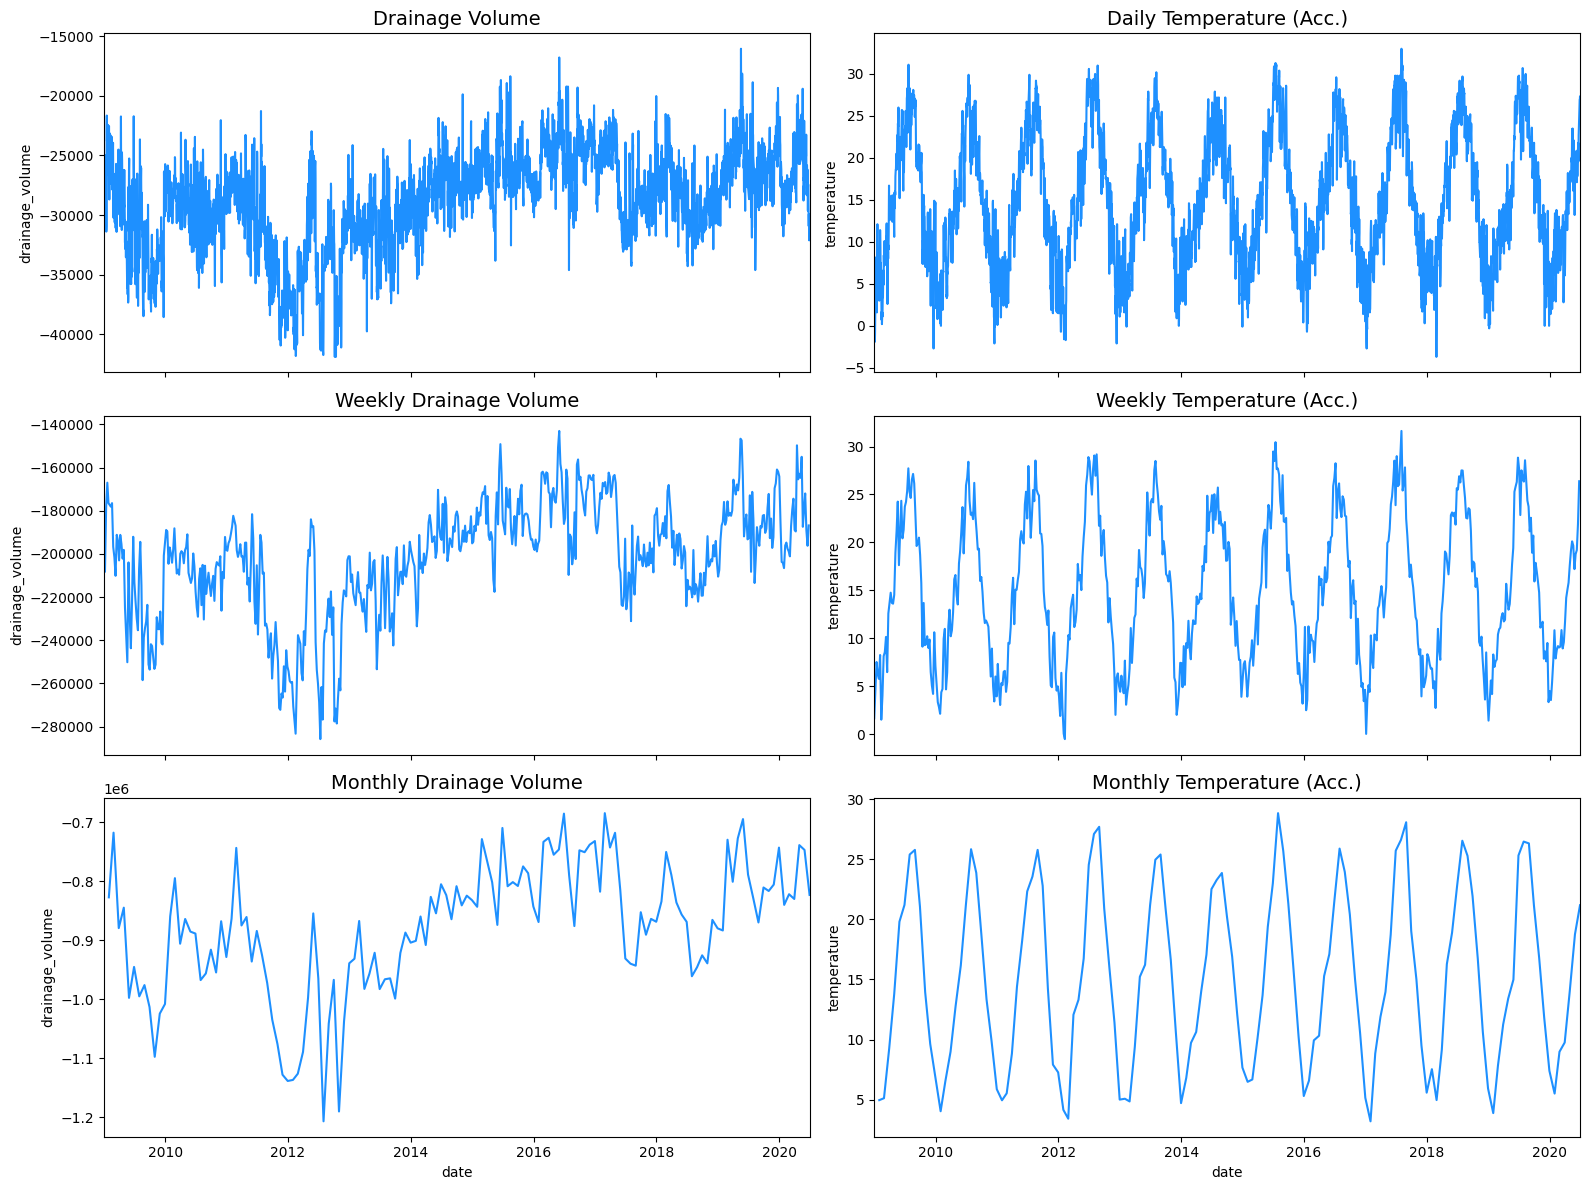

In [18]:
fig, ax = plt.subplots(ncols=2, nrows=3, sharex=True, figsize=(16, 12))

# Plotting Drainage Volume
sns.lineplot(x='date', y='drainage_volume', data=df, color='dodgerblue', ax=ax[0, 0])
ax[0, 0].set_title('Drainage Volume', fontsize=14)

# Plotting Weekly Drainage Volume
resampled_df = df[['date', 'drainage_volume']].resample('7D', on='date').sum().reset_index(drop=False)
sns.lineplot(x='date', y='drainage_volume', data=resampled_df, color='dodgerblue', ax=ax[1, 0])
ax[1, 0].set_title('Weekly Drainage Volume', fontsize=14)

# Plotting Monthly Drainage Volume
resampled_df = df[['date', 'drainage_volume']].resample('M', on='date').sum().reset_index(drop=False)
sns.lineplot(x='date', y='drainage_volume', data=resampled_df, color='dodgerblue', ax=ax[2, 0])
ax[2, 0].set_title('Monthly Drainage Volume', fontsize=14)

# Set x-axis limits for the first column
for i in range(3):
    ax[i, 0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

# Plotting Daily Temperature (Acc.)
sns.lineplot(x='date', y='temperature', data=df, color='dodgerblue', ax=ax[0, 1])
ax[0, 1].set_title('Daily Temperature (Acc.)', fontsize=14)

# Plotting Weekly Temperature (Acc.)
resampled_df = df[['date', 'temperature']].resample('7D', on='date').mean().reset_index(drop=False)
sns.lineplot(x='date', y='temperature', data=resampled_df, color='dodgerblue', ax=ax[1, 1])
ax[1, 1].set_title('Weekly Temperature (Acc.)', fontsize=14)

# Plotting Monthly Temperature (Acc.)
resampled_df = df[['date', 'temperature']].resample('M', on='date').mean().reset_index(drop=False)
sns.lineplot(x='date', y='temperature', data=resampled_df, color='dodgerblue', ax=ax[2, 1])
ax[2, 1].set_title('Monthly Temperature (Acc.)', fontsize=14)

# Setting x-axis limits for the second column
for i in range(3):
    ax[i, 1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()



In [19]:
# As we can see, downsample to weekly could smooth the data and help with analysis
downsample = df[['date',
                 'depth_to_groundwater', 
                 'temperature',
                 'drainage_volume', 
                 'river_hydrometry',
                 'rainfall'
                ]].resample('7D', on='date').mean().reset_index(drop=False)

df = downsample.copy()

## Stationary

Some time-series models, such as such as ARIMA, assume that the underlying data is stationary. Stationarity describes that the time-series has

- constant mean and mean is not time-dependent
- constant variance and variance is not time-dependent
- constant covariance and covariance is not time-dependent

The check for stationarity can be done via three different approaches:

1. visually: plot time series and check for trends or seasonality
2. basic statistics: split time series and compare the mean and variance of each partition
3. statistical test: Augmented Dickey Fuller test

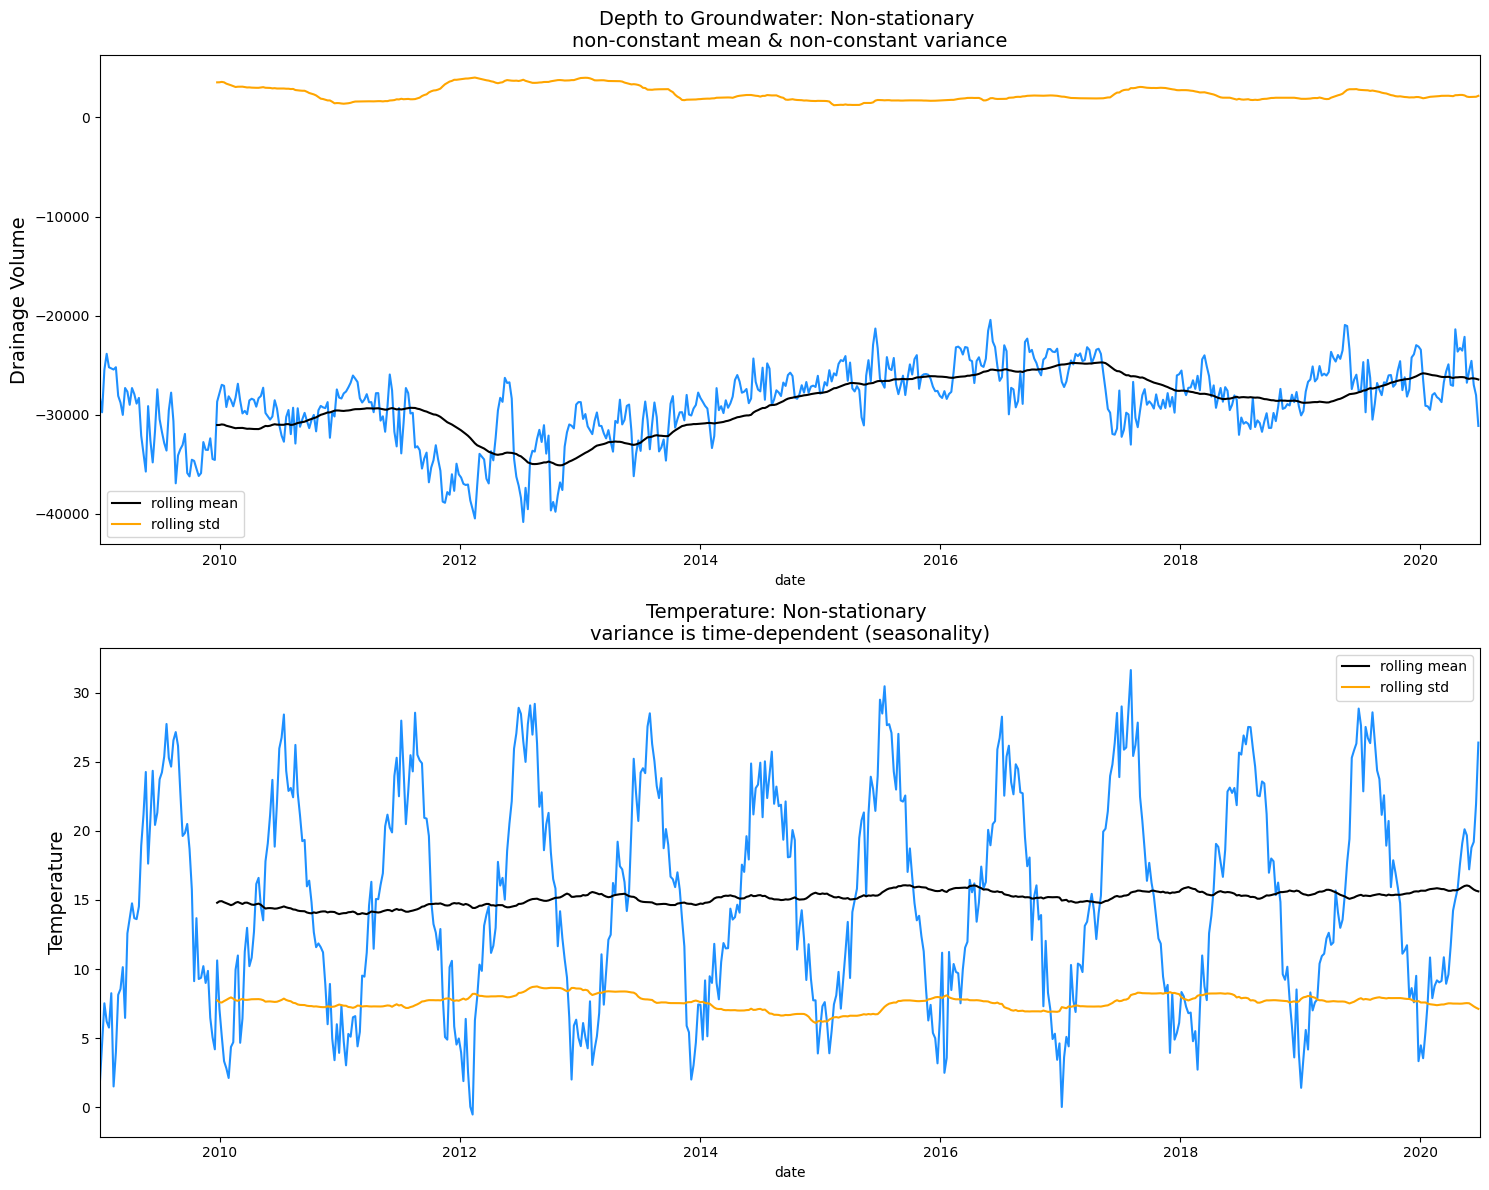

In [20]:
# A year has 52 weeks (52 weeks * 7 days per week) aporx.
rolling_window = 52
f, ax = plt.subplots(nrows=2, ncols=1, figsize=(15, 12))

sns.lineplot(x=df['date'], y=df['drainage_volume'], ax=ax[0], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).mean(), ax=ax[0], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['drainage_volume'].rolling(rolling_window).std(), ax=ax[0], color='orange', label='rolling std')
ax[0].set_title('Depth to Groundwater: Non-stationary \nnon-constant mean & non-constant variance', fontsize=14)
ax[0].set_ylabel(ylabel='Drainage Volume', fontsize=14)
ax[0].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

sns.lineplot(x=df['date'], y=df['temperature'], ax=ax[1], color='dodgerblue')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).mean(), ax=ax[1], color='black', label='rolling mean')
sns.lineplot(x=df['date'], y=df['temperature'].rolling(rolling_window).std(), ax=ax[1], color='orange', label='rolling std')
ax[1].set_title('Temperature: Non-stationary \nvariance is time-dependent (seasonality)', fontsize=14)
ax[1].set_ylabel(ylabel='Temperature', fontsize=14)
ax[1].set_xlim([date(2009, 1, 1), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

In this visual check, we can see that the features don't have constant mean and std, but they are close to it.

## Unit Root Test
Unit root is a characteristic of a time series that makes it non-stationary. And ADF test belong to the unit root test. Technically , a unit root is said to exist in a time series of value of alpha =1 in below equation.

* Yt = αYt−1 + βXe + ϵ
 
where Yt is value of the time series at time ‘t’ and Xe is an exogenous variable .

The presence of a unit root means the time series is non-stationary.

## Augmented Dickey-Fuller (ADF)

Augmented Dickey-Fuller (ADF) test is a type of statistical test called a unit root test. Unit roots are a cause for non-stationarity.

* Null Hypothesis (H0): Time series has a unit root. (Time series is not stationary).

* Alternate Hypothesis (H1): Time series has no unit root (Time series is stationary).

If the null hypothesis can be rejected, we can conclude that the time series is stationary.

- There are two ways to rejects the null hypothesis:

On the one hand, the null hypothesis can be rejected if the p-value is below a set significance level. The defaults significance level is 5%

## **p-value > significance level (default: 0.05)**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.

## **p-value <= significance level (default: 0.05)**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.
On the other hand, the null hypothesis can be rejects if the test statistic is less than the critical value.

**ADF statistic > critical value**: Fail to reject the null hypothesis (H0), the data has a unit root and is non-stationary.
**ADF statistic < critical value**: Reject the null hypothesis (H0), the data does not have a unit root and is stationary.

In [21]:
# https://www.statsmodels.org/stable/generated/statsmodels.tsa.stattools.adfuller.html
from statsmodels.tsa.stattools import adfuller
result = adfuller(df['depth_to_groundwater'].values)
result

(-3.098165286840192,
 0.026689263749965872,
 6,
 593,
 {'1%': -3.4414256033746606,
  '5%': -2.8664262627821473,
  '10%': -2.569372254520843},
 -722.23429154102)

Now, we are going to check for each variable:

* The p-value is less than 0.05
* Check the range of the ADF statistic compared with critical_values

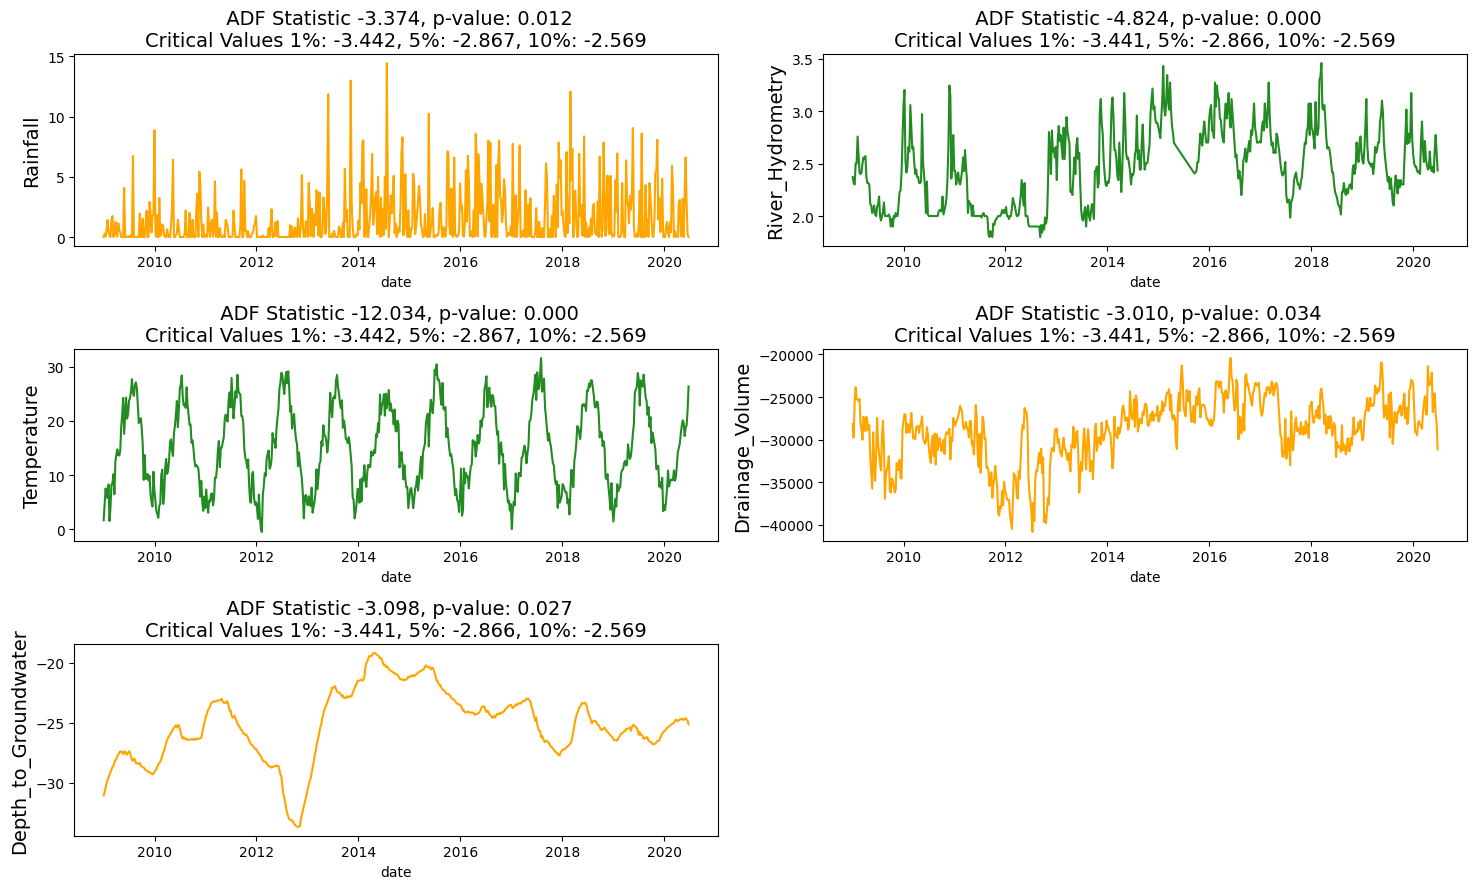

In [22]:
f, ax = plt.subplots(nrows=3, ncols=2, figsize=(15, 9))

def visualize_adfuller_results(series, title, ax):
    result = adfuller(series)
    significance_level = 0.05
    adf_stat = result[0]
    p_val = result[1]
    crit_val_1 = result[4]['1%']
    crit_val_5 = result[4]['5%']
    crit_val_10 = result[4]['10%']

    if (p_val < significance_level) & ((adf_stat < crit_val_1)):
        linecolor = 'forestgreen'

    elif (p_val < significance_level) & (adf_stat < crit_val_5):
        linecolor = 'orange'

    elif (p_val < significance_level) & (adf_stat < crit_val_10):
        linecolor = 'red'

    else:
        linecolor = 'purple'

    sns.lineplot(x=df['date'], y=series, ax=ax, color=linecolor)
    ax.set_title(f' ADF Statistic {adf_stat:0.3f}, p-value: {p_val:0.3f}\nCritical Values 1%: {crit_val_1:0.3f}, 5%: {crit_val_5:0.3f}, 10%: {crit_val_10:0.3f}', fontsize=14)

    ax.set_ylabel(ylabel=title, fontsize=14)

visualize_adfuller_results(df['rainfall'].values, 'Rainfall', ax[0, 0])
visualize_adfuller_results(df['temperature'].values, 'Temperature', ax[1, 0])
visualize_adfuller_results(df['river_hydrometry'].values, 'River_Hydrometry', ax[0, 1])
visualize_adfuller_results(df['drainage_volume'].values, 'Drainage_Volume', ax[1, 1])
visualize_adfuller_results(df['depth_to_groundwater'].values, 'Depth_to_Groundwater', ax[2, 0])

f.delaxes(ax[2, 1])
plt.tight_layout()
plt.show()



If the data is not stationary but we want to use a model such as ARIMA (that requires this characteristic), the data has to be transformed.

The two most common methods to transform series into stationarity ones are:

* Transformation: e.g. log or square root to stabilize non-constant variance
* Differencing: subtracts the current value from the previous

# Transforming

C:\Users\PC\AppData\Local\Temp\ipykernel_26676\3664128879.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['depth_to_groundwater_log'], ax=ax[1])


<AxesSubplot: xlabel='depth_to_groundwater_log', ylabel='Density'>

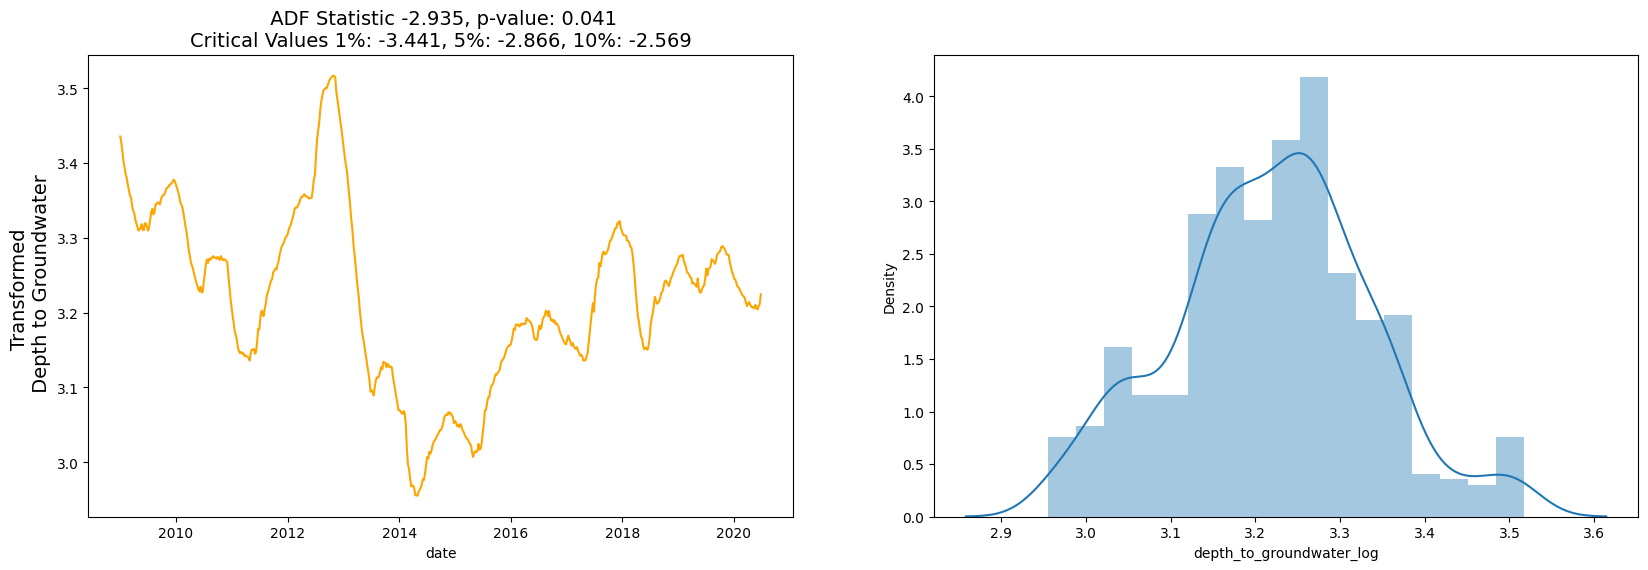

In [23]:
# Log Transform of absolute values
# (Log transoform of negative values will return NaN)
df['depth_to_groundwater_log'] = np.log(abs(df['depth_to_groundwater']))

f, ax = plt.subplots(nrows=1, ncols=2, figsize=(20, 6))
visualize_adfuller_results(df['depth_to_groundwater_log'], 'Transformed \n Depth to Groundwater', ax[0])
sns.distplot(df['depth_to_groundwater_log'], ax=ax[1])

Differencing can be done in different orders:

* First order differencing: linear trends with  zi= yi−  yi−1
 
* Second-order differencing: quadratic trends with  zi= (yi−yi−1)−(yi−1−yi−2)
 
and so on...

# Differentiating

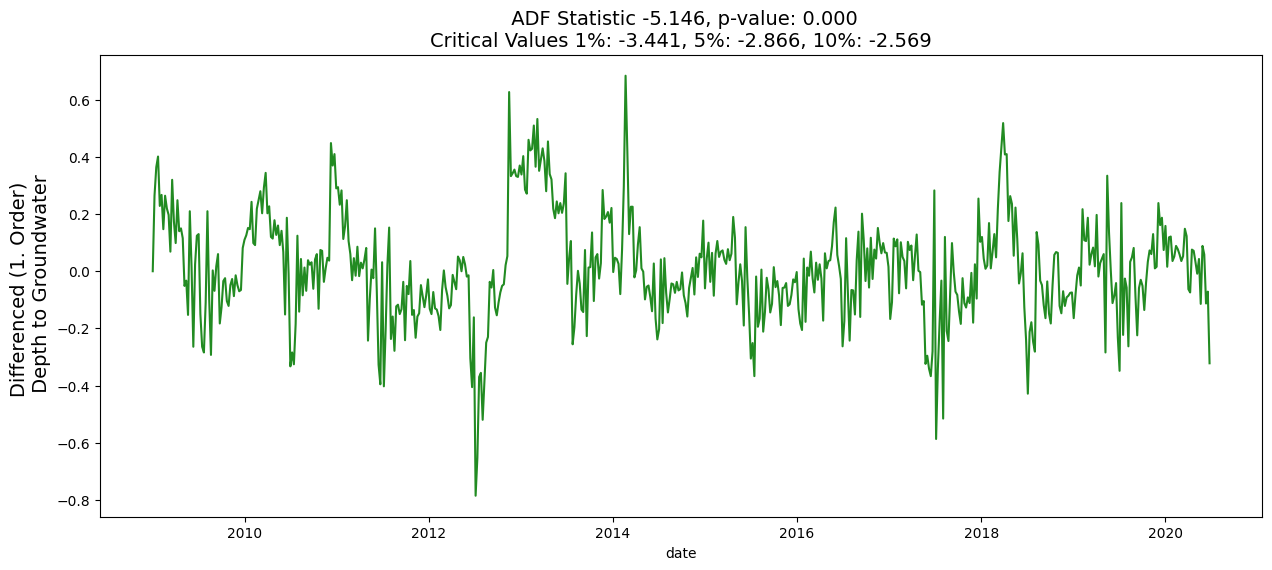

In [24]:
# First Order Differencing
ts_diff = np.diff(df['depth_to_groundwater'])
df['depth_to_groundwater_diff_1'] = np.append([0], ts_diff)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(15, 6))
visualize_adfuller_results(df['depth_to_groundwater_diff_1'], 'Differenced (1. Order) \n Depth to Groundwater', ax)

# Feature Engineering

In [25]:


# # Assuming 'date' is a column in your DataFrame 'df' containing datetime values
# df['year'] = pd.DatetimeIndex(df['date']).year
# df['month'] = pd.DatetimeIndex(df['date']).month
# df['day'] = pd.DatetimeIndex(df['date']).day
# df['day_of_year'] = pd.DatetimeIndex(df['date']).dayofyear
# df['week_of_year'] = pd.DatetimeIndex(df['date']).isocalender().week  # Use 'isocalendar().week'
# df['quarter'] = pd.DatetimeIndex(df['date']).quarter
# df['season'] = df['month'] % 12 // 3 + 1

# df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()



# Assuming 'date' is a column in your DataFrame 'df' containing datetime values
df['year'] = pd.to_datetime(df['date']).dt.year
df['month'] = pd.to_datetime(df['date']).dt.month
df['day'] = pd.to_datetime(df['date']).dt.day
df['day_of_year'] = pd.to_datetime(df['date']).dt.dayofyear
df['week_of_year'] = pd.to_datetime(df['date']).dt.isocalendar().week  # Corrected 'isocalendar().week'
df['quarter'] = pd.to_datetime(df['date']).dt.quarter
df['season'] = pd.to_datetime(df['date']).dt.month % 12 // 3 + 1

df[['date', 'year', 'month', 'day', 'day_of_year', 'week_of_year', 'quarter', 'season']].head()


,date,year,month,day,day_of_year,week_of_year,quarter,season
0,2009-01-01,2009,1,1,1,1,1,1
1,2009-01-08,2009,1,8,8,2,1,1
2,2009-01-15,2009,1,15,15,3,1,1
3,2009-01-22,2009,1,22,22,4,1,1
4,2009-01-29,2009,1,29,29,5,1,1


# Enconding Cyclical Features

The new time features are cyclical. For example,the feature month cycles between 1 and 12 for every year. While the difference between each month increments by 1 during the year, between two years the month feature jumps from 12 (December) to 1 (January). This results in a -11 difference, which can confuse a lot of models.

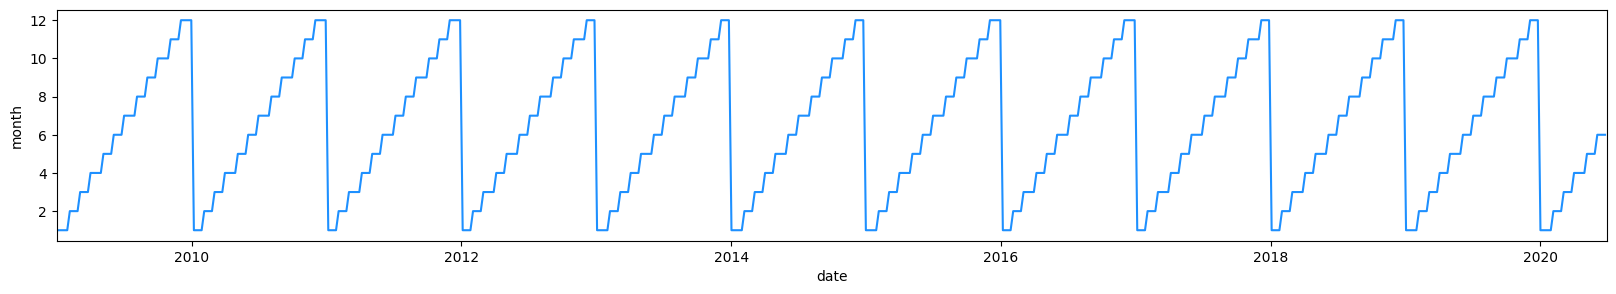

In [26]:
f, ax = plt.subplots(nrows=1, ncols=1, figsize=(20, 3))

sns.lineplot(x=df['date'], y=df['month'], color='dodgerblue')
ax.set_xlim([date(2009, 1, 1), date(2020, 6, 30)])
plt.show()

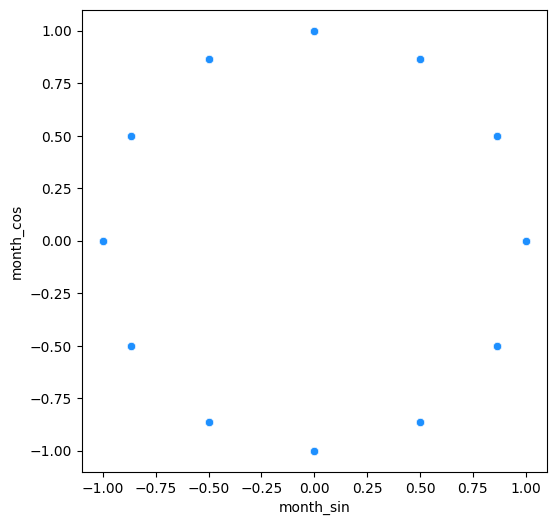

In [27]:
month_in_year = 12
df['month_sin'] = np.sin(2*np.pi*df['month']/month_in_year)
df['month_cos'] = np.cos(2*np.pi*df['month']/month_in_year)

f, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
sns.scatterplot(x=df.month_sin, y=df.month_cos, color='dodgerblue')
plt.show()


## TimeSeries Decomposition

Time series decomposition involves thinking of a series as a combination of level, trend, seasonality, and noise components.

These components are defined as follows:

* Level: The average value in the series.
* Trend: The increasing or decreasing value in the series.
* Seasonality: The repeating short-term cycle in the series.
* Noise: The random variation in the series.


Decomposition provides a useful abstract model for thinking about time series generally and for better understanding problems during time series analysis and forecasting.

All series have a level and noise. The trend and seasonality components are optional.

It is helpful to think of the components as combining either additively or multiplicatively:

* Additive:  y(t) = Level + Trend + Seasonality + Noise

 
* Multiplicative:  y(t) = Level * Trend * Seasonality * Noise



In this case we are going to use function seasonal_decompose() from the statsmodels library.

In [28]:
from statsmodels.tsa.seasonal import seasonal_decompose

core_columns =  [
    'rainfall', 'temperature', 'drainage_volume', 
    'river_hydrometry', 'depth_to_groundwater'
]

for column in core_columns:
    decomp = seasonal_decompose(df[column], period=52, model='additive', extrapolate_trend='freq')
    df[f"{column}_trend"] = decomp.trend
    df[f"{column}_seasonal"] = decomp.seasonal

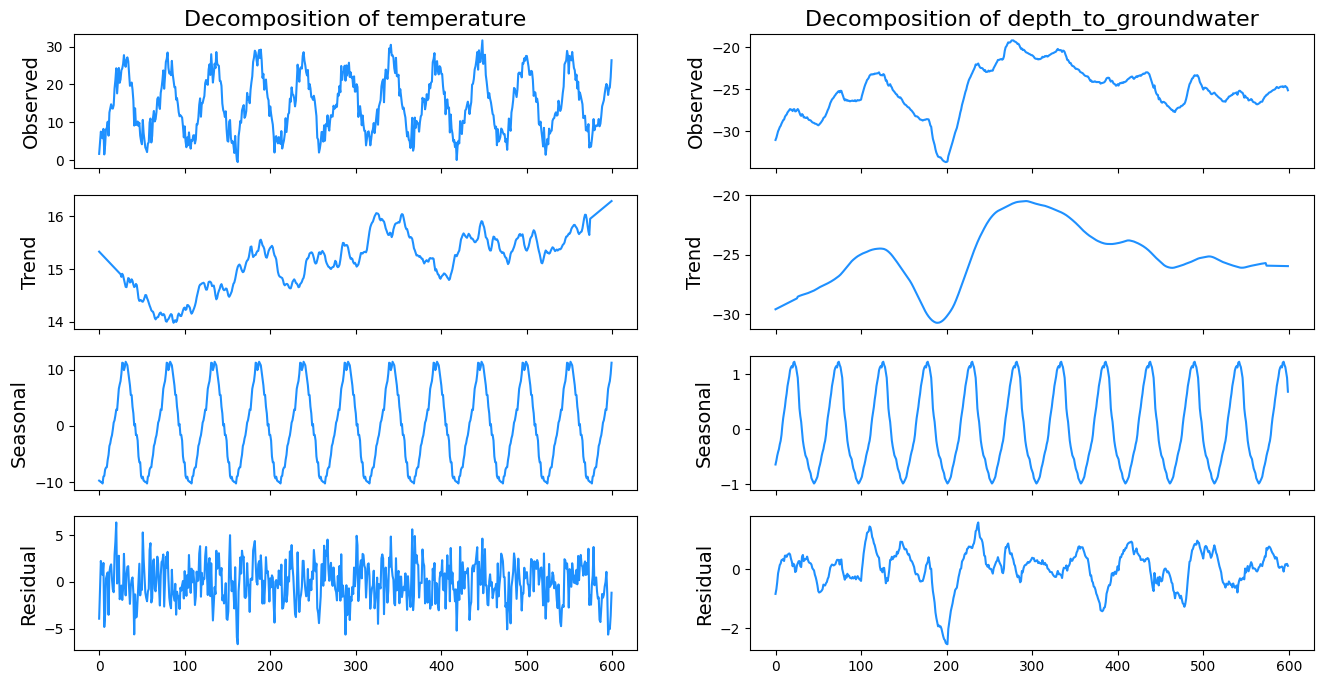

In [29]:
from statsmodels.tsa.seasonal import seasonal_decompose

fig, ax = plt.subplots(ncols=2, nrows=4, sharex=True, figsize=(16, 8))

for i, column in enumerate(['temperature', 'depth_to_groundwater']):
    res = seasonal_decompose(df[column], model='additive', period=52,  extrapolate_trend='freq')
    
    ax[0, i].set_title('Decomposition of {}'.format(column), fontsize=16)
    res.observed.plot(ax=ax[0, i], legend=False, color='dodgerblue')
    ax[0, i].set_ylabel('Observed', fontsize=14)

    res.trend.plot(ax=ax[1, i], legend=False, color='dodgerblue')
    ax[1, i].set_ylabel('Trend', fontsize=14)

    res.seasonal.plot(ax=ax[2, i], legend=False, color='dodgerblue')
    ax[2, i].set_ylabel('Seasonal', fontsize=14)

    res.resid.plot(ax=ax[3, i], legend=False, color='dodgerblue')
    ax[3, i].set_ylabel('Residual', fontsize=14)

plt.show()


# Lag
We want to calculate each variable with a shift() (lag) to compare the correlationwith the other variables.

In [30]:
weeks_in_month = 4
for column in core_columns:
    df[f'{column}_seasonal_shift_b_2m'] = df[f'{column}_seasonal'].shift(-2 * weeks_in_month)
    df[f'{column}_seasonal_shift_b_1m'] = df[f'{column}_seasonal'].shift(-1 * weeks_in_month)
    df[f'{column}_seasonal_shift_1m'] = df[f'{column}_seasonal'].shift(1 * weeks_in_month)
    df[f'{column}_seasonal_shift_2m'] = df[f'{column}_seasonal'].shift(2 * weeks_in_month)
    df[f'{column}_seasonal_shift_3m'] = df[f'{column}_seasonal'].shift(3 * weeks_in_month)

## Exploratory Data Analysis 


- Now, we are going to plot the data and try to extract some knowledge.



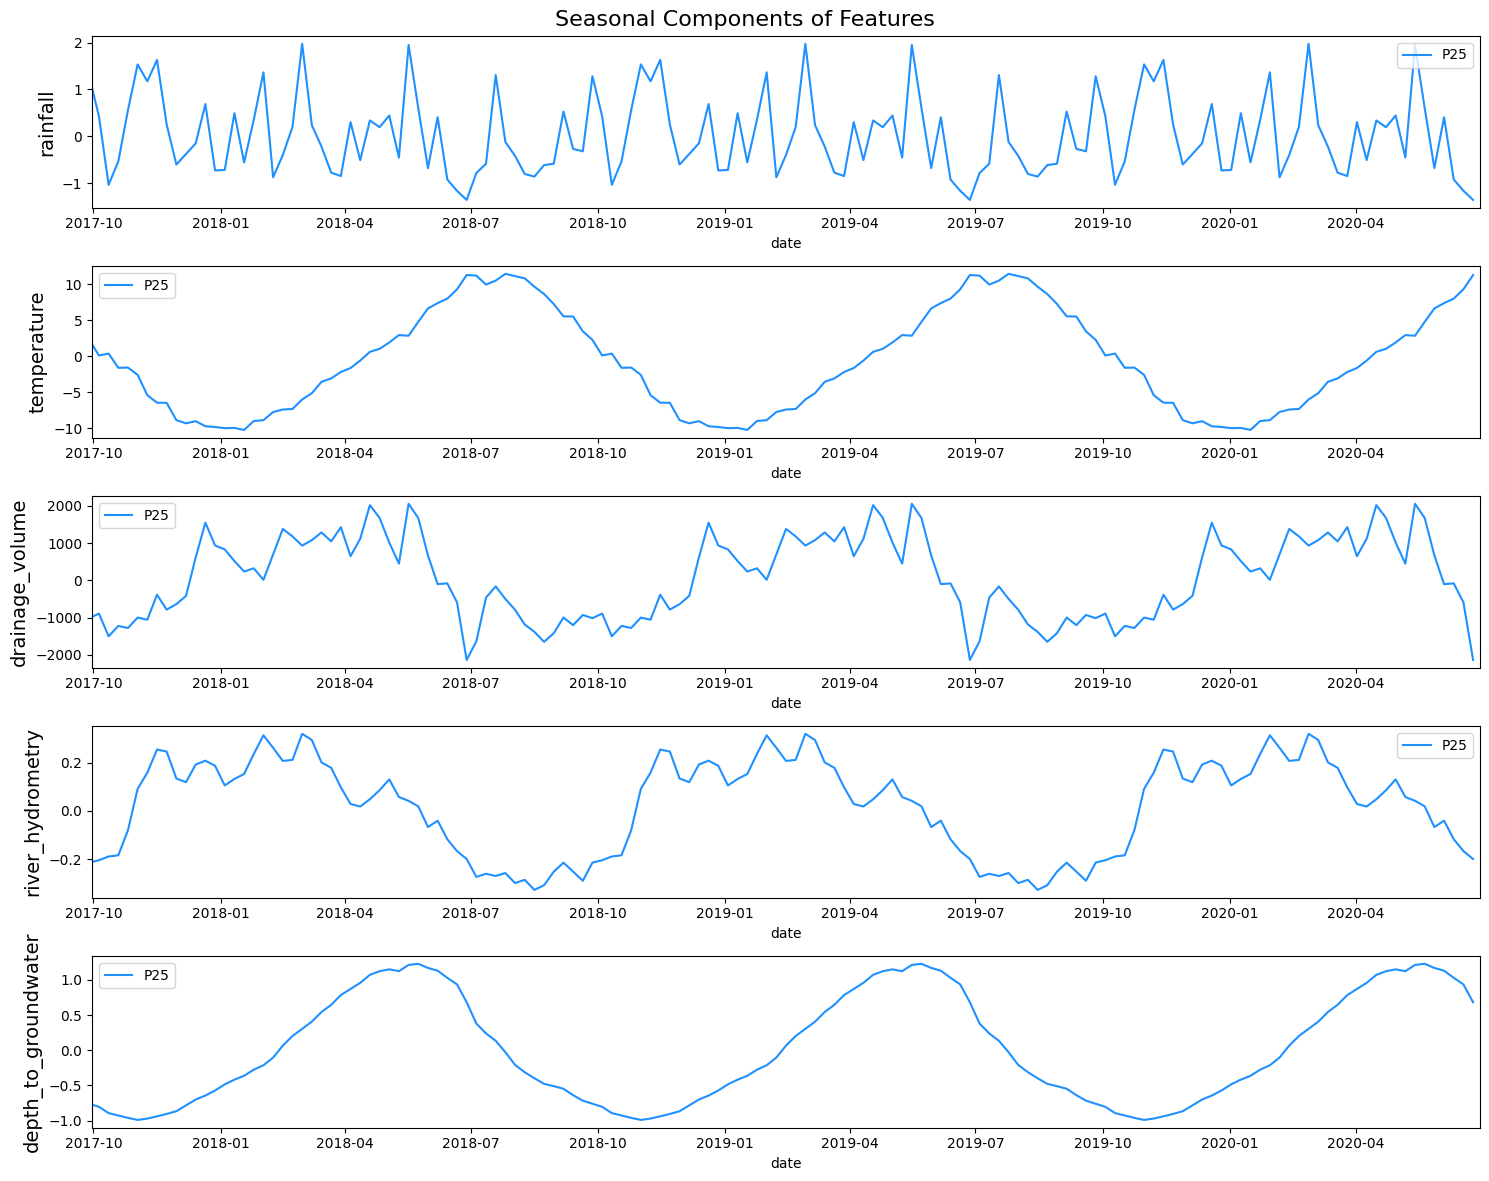

In [31]:
f, ax = plt.subplots(nrows=5, ncols=1, figsize=(15, 12))
f.suptitle('Seasonal Components of Features', fontsize=16)


for i, column in enumerate(core_columns):
    sns.lineplot(x=df['date'], y=df[column + '_seasonal'], ax=ax[i], color='dodgerblue', label='P25')
    ax[i].set_ylabel(ylabel=column, fontsize=14)
    ax[i].set_xlim([date(2017, 9, 30), date(2020, 6, 30)])

plt.tight_layout()
plt.show()

## Observation

- depth_to_groundwater: reaches its maximum around May/June and its minimum around November
- temperature: reaches its maxmium around August and its minimum around January
- drainage_volume: reaches its minimum around July.
- river_hydrometry: reaches its maximum around February/March and its minimum around September

# Correlation

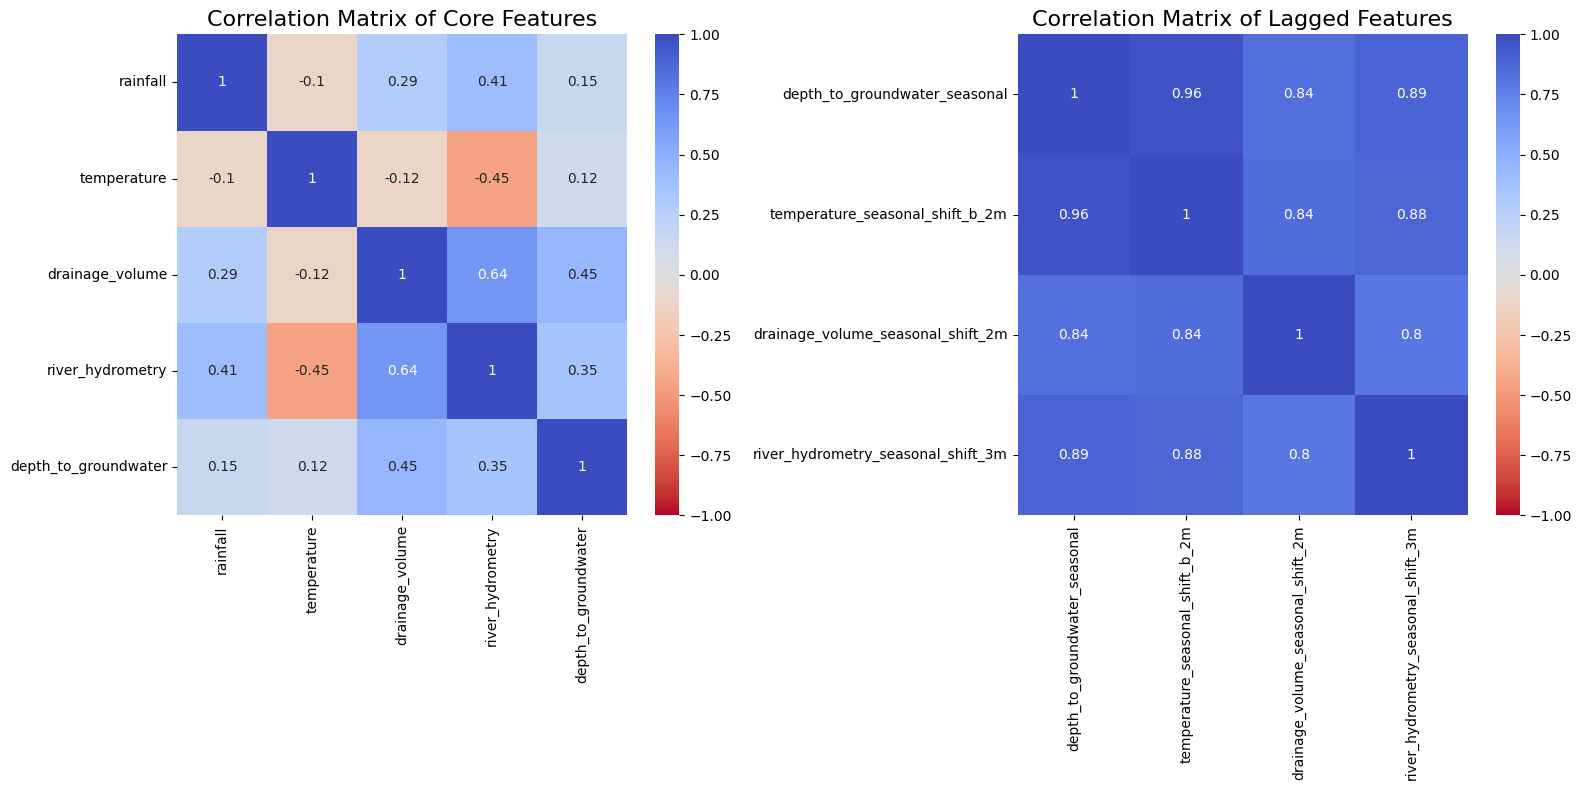

In [32]:
f, ax = plt.subplots(nrows=1, ncols=2, figsize=(16, 8))

corrmat = df[core_columns].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[0])
ax[0].set_title('Correlation Matrix of Core Features', fontsize=16)


shifted_cols = [ 'depth_to_groundwater_seasonal',
                'temperature_seasonal_shift_b_2m',
                'drainage_volume_seasonal_shift_2m',
                'river_hydrometry_seasonal_shift_3m']

corrmat = df[shifted_cols].corr()

sns.heatmap(corrmat, annot=True, vmin=-1, vmax=1, cmap='coolwarm_r', ax=ax[1])
ax[1].set_title('Correlation Matrix of Lagged Features', fontsize=16)
plt.tight_layout()
plt.show()


As we can see, the features are higher correlated in the case of shifted features (lagged ones) than the original ones.

## Autocorrelatin Analysis

ACF and PACF plots: After a time series has been stationarized by differencing, the next step in fitting an ARIMA model is to determine whether AR or MA terms are needed to correct any autocorrelation that remains in the differenced series. Of course, with software like Statgraphics, you could just try some different combinations of terms and see what works best. But there is a more systematic way to do this. By looking at the autocorrelation function (ACF) and partial autocorrelation (PACF) plots of the differenced series, you can tentatively identify the numbers of AR and/or MA terms that are needed.

- Autocorrelation Function (ACF): P = Periods to lag for eg: (if P= 3 then we will use the three previous periods of our time series in the autoregressive portion of the calculation) P helps adjust the line that is being fitted to forecast the series. P corresponds with MA parameter

- Partial Autocorrelation Function (PACF): D = In an ARIMA model we transform a time series into stationary one(series without trend or seasonality) using differencing. D refers to the number of differencing transformations required by the time series to get stationary. D corresponds with AR parameter.

Autocorrelation plots help in detecting seasonality.

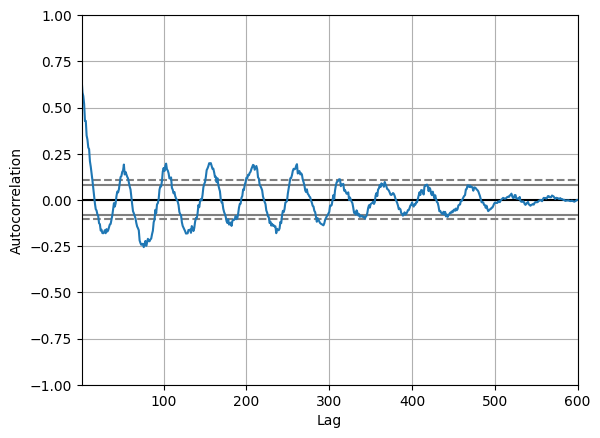

In [33]:
from pandas.plotting import autocorrelation_plot

autocorrelation_plot(df['depth_to_groundwater_diff_1'])
plt.show()

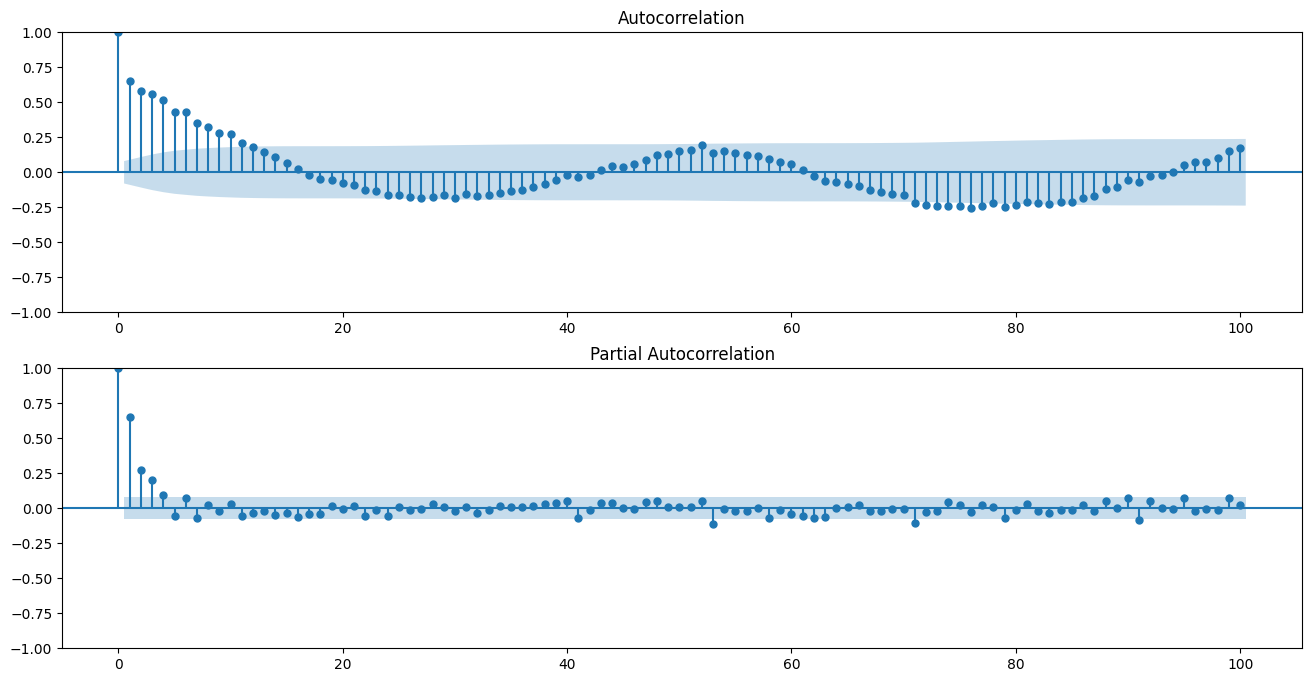

In [34]:
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf

f, ax = plt.subplots(nrows=2, ncols=1, figsize=(16, 8))

plot_acf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[0])
plot_pacf(df['depth_to_groundwater_diff_1'], lags=100, ax=ax[1])

plt.show()

## Modeling 
Time series can be either univariate or multivariate:

- Univariate time series only has a single time-dependent variable.

- Multivariate time series have a multiple time-dependent variable.


But, first of all we are going to see how does cross-validation technic works in TimeSeries Analysis.



In [35]:
from sklearn.model_selection import TimeSeriesSplit

N_SPLITS = 3

X = df['date']
y = df['depth_to_groundwater']

folds = TimeSeriesSplit(n_splits=N_SPLITS)


In [38]:
import plotly.express as px
import plotly.graph_objs as go
from plotly.subplots import make_subplots  # Import make_subplots

# Create subplots
fig = make_subplots(rows=N_SPLITS, cols=2, subplot_titles=[f"Split {i+1}" for i in range(N_SPLITS)])

for i, (train_index, valid_index) in enumerate(folds.split(X)):
    X_train, X_valid = X[train_index], X[valid_index]
    y_train, y_valid = y[train_index], y[valid_index]

    # Plot training data
    train_trace = go.Scatter(x=X_train, y=y_train, mode='lines', name='Train', line=dict(color='dodgerblue'))
    fig.add_trace(train_trace, row=i + 1, col=1)

    # Plot validation data
    valid_trace = go.Scatter(x=X_valid, y=y_valid, mode='lines', name='Validation', line=dict(color='darkorange'))
    fig.add_trace(valid_trace, row=i + 1, col=1)

    # Plot training data with constant size
    X_train_const = X_train[len(X_train) - len(X_valid):]
    y_train_const = y_train[len(X_train) - len(X_valid):]
    train_const_trace = go.Scatter(x=X_train_const, y=y_train_const, mode='lines', name='Train (Constant)', line=dict(color='dodgerblue'))
    fig.add_trace(train_const_trace, row=i + 1, col=2)

    # Plot validation data with constant size
    valid_const_trace = go.Scatter(x=X_valid, y=y_valid, mode='lines', name='Validation', line=dict(color='darkorange'))
    fig.add_trace(valid_const_trace, row=i + 1, col=2)

    # Set x-axis limits
    fig.update_xaxes(range=[date(2009, 1, 1), date(2020, 6, 30)], row=i + 1, col=1)
    fig.update_xaxes(range=[date(2009, 1, 1), date(2020, 6, 30)], row=i + 1, col=2)

# Set subplot titles and layout
fig.update_layout(
    title_text="Rolling Window Visualization",
    showlegend=False,
    height=900,
    width=1000,
)

# Show the interactive chart
fig.show()


The idea with this plot is to understand which train and test set are we using to fit the model in each iteration.

# Models for Univariate Time Series

First of all, we are going to analize univariate TimeSeries forecasting.

Univariate time series: Only one variable is varying over time. For example, data collected from a sensor measuring the temperature of a room every second. Therefore, each second, you will only have a one-dimensional value, which is the temperature.

In [39]:
train_size = int(0.85 * len(df))
test_size = len(df) - train_size

univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

train = univariate_df.iloc[:train_size, :]

x_train, y_train = pd.DataFrame(univariate_df.iloc[:train_size, 0]), pd.DataFrame(univariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(univariate_df.iloc[train_size:, 0]), pd.DataFrame(univariate_df.iloc[train_size:, 1])

print(len(train), len(x_valid))

510 90


## LSTM

In [40]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from math import sqrt
import plotly.graph_objs as go
from plotly.subplots import make_subplots
import pandas as pd
from datetime import date

# Ensure your data is in the right format
train_data = np.array(y_train).reshape(-1, 1)
valid_data = np.array(y_valid).reshape(-1, 1)

# Normalize the data
scaler = MinMaxScaler()
train_data = scaler.fit_transform(train_data)
valid_data = scaler.transform(valid_data)

# Create sequences for training data
sequence_length = 10  # Adjust as needed
X_train, y_train = [], []

for i in range(sequence_length, len(train_data)):
    X_train.append(train_data[i - sequence_length:i, 0])
    y_train.append(train_data[i, 0])

X_train, y_train = np.array(X_train), np.array(y_train)

# Create sequences for validation data
X_valid, y_valid = [], []

for i in range(sequence_length, len(valid_data)):
    X_valid.append(valid_data[i - sequence_length:i, 0])
    y_valid.append(valid_data[i, 0])

X_valid, y_valid = np.array(X_valid), np.array(y_valid)

# Build the LSTM model
model = Sequential()
model.add(LSTM(units=50, activation='relu', input_shape=(X_train.shape[1], 1)))
model.add(Dense(units=1))
model.compile(optimizer='adam', loss='mean_squared_error')

# Train the model
model.fit(X_train, y_train, epochs=50, batch_size=64)

# Make predictions
y_pred = model.predict(X_valid)

# Inverse transform to get actual values
y_pred = scaler.inverse_transform(y_pred)
y_valid = scaler.inverse_transform(y_valid.reshape(-1, 1))

# Calculate RMSE
rmse = sqrt(mean_squared_error(y_valid, y_pred))
print("Root Mean Squared Error (RMSE):", rmse)

# Create a DataFrame for visualization
univariate_df = df[['date', 'depth_to_groundwater']].copy()
univariate_df.columns = ['ds', 'y']

# Create an interactive subplot
fig = make_subplots(rows=1, cols=1)

# Add the true values as a trace
true_trace = go.Scatter(
    x=univariate_df['ds'][-len(y_valid):],
    y=y_valid.flatten(),
    mode='lines',
    name='True'
)

# Add the predicted values as a trace
predicted_trace = go.Scatter(
    x=univariate_df['ds'][-len(y_pred):],
    y=y_pred.flatten(),
    mode='lines',
    name='Predicted'
)

fig.add_trace(true_trace)
fig.add_trace(predicted_trace)

# Customize the layout
fig.update_layout(
    title='Depth to Groundwater Forecasting with LSTM',
    xaxis_title='Date',
    yaxis_title='Depth to Groundwater'
)

# Show the interactive chart
fig.show()


Epoch 1/50
8/8 [==============================] - 4s 10ms/step - loss: 0.3360
Epoch 2/50
8/8 [==============================] - 0s 9ms/step - loss: 0.2398
Epoch 3/50
8/8 [==============================] - 0s 9ms/step - loss: 0.1423
Epoch 4/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0587
Epoch 5/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0085
Epoch 6/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0099
Epoch 7/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0047
Epoch 8/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0035
Epoch 9/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0028
Epoch 10/50
8/8 [==============================] - 0s 9ms/step - loss: 0.0026
Epoch 11/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0024
Epoch 12/50
8/8 [==============================] - 0s 10ms/step - loss: 0.0022
Epoch 13/50
8/8 [==============================] - 0s 10ms/step - 

## forecasting 

In [53]:
# Define scaled_future_data using the same scaler as before
# Replace 'future_data' with your actual future data, which is the 'depth_to_groundwater' feature
# Assuming your future data is stored in a variable 'future_depth_to_groundwater'
future_data = univariate_df['y'].values.reshape(-1, 1)
scaled_future_data = scaler.transform(future_data)

# Define forecast_period (the number of future data points you want to predict)
forecast_period = 30  # Adjust this based on the number of future time steps you want to predict

# Initialize X_future with the last available data points
X_future = scaled_future_data[-sequence_length:].reshape(1, sequence_length, 1)

# Make future predictions
future_predictions = []

for _ in range(forecast_period):
    # Reshape X_future for prediction
    prediction = model.predict(X_future)
    future_predictions.append(prediction[0, 0])
    
    # Update X_future by removing the first element and adding the predicted value
    X_future = np.concatenate((X_future[:, 1:, :], prediction.reshape(1, 1, 1)))

# Inverse transform to get actual values for future predictions
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Create the future dates for forecasting
end_date = univariate_df['ds'].max()  # Adjust this based on your data
future_dates = pd.date_range(start=end_date + timedelta(days=1), periods=forecast_period, freq='D')

# Create a DataFrame for future predictions
future_dates_df = pd.DataFrame({'ds': future_dates, 'y': future_predictions})

# Concatenate the original and future data
extended_univariate_df = pd.concat([univariate_df, future_dates_df], ignore_index=True)

# Create an interactive subplot for the extended time series
fig = make_subplots(rows=1, cols=1)

# Add the true values as a trace
true_trace = go.Scatter(
    x=extended_univariate_df['ds'],
    y=extended_univariate_df['y'],
    mode='lines',
    name='True'
)

fig.add_trace(true_trace)

# Customize the layout for the extended time series
fig.update_layout(
    title='Extended Depth to Groundwater Forecasting with LSTM',
    xaxis_title='Date',
    yaxis_title='Depth to Groundwater'
)

# Show the interactive chart for the extended time series
fig.show()


TypeError: in user code:

    File "c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2169, in predict_function  *
        return step_function(self, iterator)
    File "c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2155, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2143, in run_step  **
        outputs = model.predict_step(data)
    File "c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\engine\training.py", line 2111, in predict_step
        return self(x, training=False)
    File "c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\Users\PC\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\layers\rnn\lstm.py", line 615, in call
        timesteps = input_shape[0] if self.time_major else input_shape[1]

    TypeError: Exception encountered when calling layer 'lstm' (type LSTM).
    
    'NoneType' object is not subscriptable
    
    Call arguments received by layer 'lstm' (type LSTM):
      • inputs=tf.Tensor(shape=<unknown>, dtype=float32)
      • mask=None
      • training=False
      • initial_state=None


## Prophet

The first model (which also can handle multivariate problems) we are going to try is Facebook Prophet.

Prophet, or “Facebook Prophet,” is an open-source library for univariate (one variable) time series forecasting developed by Facebook.

Prophet implements what they refer to as an additive time series forecasting model, and the implementation supports trends, seasonality, and holidays.

In [ ]:
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import math
# from holidays.countries import Entity

# from fbprophet import Prophet


# # Train the model
# model = Prophet()
# model.fit(train)

# # x_valid = model.make_future_dataframe(periods=test_size, freq='w')

# # Predict on valid set
# y_pred = model.predict(x_valid)

# # Calcuate metrics
# score_mae = mean_absolute_error(y_valid, y_pred.tail(test_size)['yhat'])
# score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred.tail(test_size)['yhat']))

# print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

## Forecasting

In [ ]:
# # Plot the forecast
# f, ax = plt.subplots(1)
# f.set_figheight(6)
# f.set_figwidth(15)

# model.plot(y_pred, ax=ax)
# sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

# ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
# ax.set_xlabel(xlabel='Date', fontsize=14)
# ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

# plt.show()

## ARIMA

The second model that i want to try is ARIMA.

The Auto-Regressive Integrated Moving Average (ARIMA) model describes the __autocorrelations in the data. The model assumes that the time-series is __stationary. It consists of three main parts:

* Auto-Regressive (AR) filter (long term):
yt = c + α1 yt − 1 + .... + αp yt−p + ϵt = c+∑pi=1 αi yt−i + ϵt -> p

* Integration filter (stochastic trend)

-> d

* Moving Average (MA) filter (short term):

yt = c + ϵt + β1ϵt−1 +    ⋯  + βqϵt−q = c + ϵt +∑qi=1 βiϵt−i  -> q

__ARIMA:  
yt = c + α1yt−1 +... + αpyt−p + ϵt + β1ϵt−1 + ... + βqϵt−q
 
ARIMA( p, d, q)

* p: Lag order (reference PACF in Autocorrelation Analysis)
* d: Degree of differencing. (reference Differencing in Stationarity)
* q: Order of moving average (check out ACF in Autocorrelation Analysis)


Steps to analyze ARIMA
* Step 1 — Check stationarity: If a time series has a trend or seasonality component, it must be made stationary before we can use ARIMA to forecast. .
* Step 2 — Difference: If the time series is not stationary, it needs to be stationarized through differencing. Take the first difference, then check for stationarity. Take as many differences as it takes. Make sure you check seasonal differencing as well.
* Step 3 — Filter out a validation sample: This will be used to validate how accurate our model is. Use train test validation split to achieve this
* Step 4 — Select AR and MA terms: Use the ACF and PACF to decide whether to include an AR term(s), MA term(s), or both.
* Step 5 — Build the model: Build the model and set the number of periods to forecast to N (depends on your needs).
* Step 6 — Validate model: Compare the predicted values to the actuals in the validation sample.

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
import math
from sklearn.metrics import mean_absolute_error, mean_squared_error
from colorama import Fore

# Fit model
model = ARIMA(y_train, order=(1,1,1))
model_fit = model.fit()

# Prediction with ARIMA
y_pred = model_fit.forecast(steps=90)  # Change 'forecast(90)' to 'forecast(steps=90)'

# Calculate metrics
score_mae = mean_absolute_error(y_valid, y_pred)
score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred))

print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))
print(Fore.GREEN + 'MAE: {}'.format(score_mae))


RMSE: 1.3984562317544382
MAE: 1.195588074327848


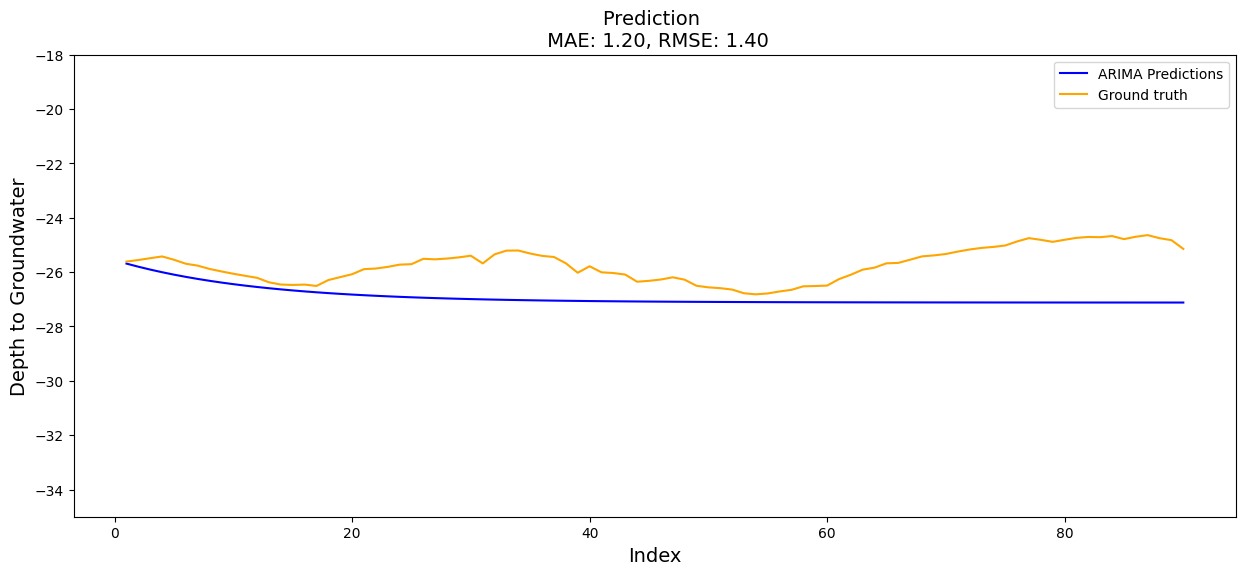

In [ ]:

# f, ax = plt.subplots(1)
# f.set_figheight(6)
# f.set_figwidth(15)

# model_fit.plot_predict(1, 599, ax=ax)
# sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

# ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
# ax.set_xlabel(xlabel='Date', fontsize=14)
# ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

# ax.set_ylim(-35, -18)
# plt.show()


import matplotlib.pyplot as plt

# Create a range of indices to match the length of your validation data
indices = range(1, len(x_valid) + 1)

plt.figure(figsize=(15, 6))
plt.plot(indices, y_pred, label='ARIMA Predictions', color='blue')
plt.plot(indices, y_valid['y'], label='Ground truth', color='orange')
plt.title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
plt.xlabel('Index', fontsize=14)  # Use index as x-axis instead of date
plt.ylabel('Depth to Groundwater', fontsize=14)
plt.ylim(-35, -18)
plt.legend()
plt.show()





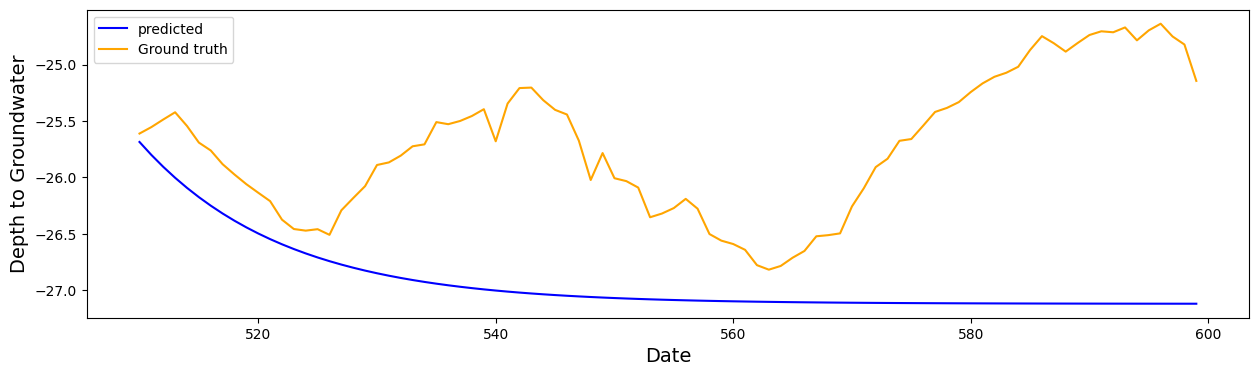

In [ ]:
f, ax = plt.subplots(1)
f.set_figheight(4)
f.set_figwidth(15)

sns.lineplot(x=x_valid.index, y=y_pred, ax=ax, color='blue', label='predicted') #navajowhite
sns.lineplot(x=x_valid.index, y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

## Auto Arima

In [ ]:
from statsmodels.tsa.arima_model import ARIMA
import pmdarima as pm

model = pm.auto_arima(y_train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3, # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0, 
                      D=0, 
                      trace=True,
                      error_action='ignore',  
                      suppress_warnings=True, 
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=-617.425, Time=0.41 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=-237.968, Time=0.09 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=-559.046, Time=0.17 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=-418.724, Time=0.15 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=-238.345, Time=0.04 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=-615.487, Time=0.96 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=-615.513, Time=0.85 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=-480.494, Time=0.26 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=-595.884, Time=0.28 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=-614.338, Time=1.17 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=-619.284, Time=0.18 sec
 ARIMA(0,1,1)(0,0,0)[0]             : AIC=-419.649, Time=0.08 sec
 ARIMA(1,1,0)(0,0,0)[0]             : AIC=-560.728, Time=0.06 sec
 ARIMA(2,1,1)(0,0,0)[0]             : AIC=-617.346, Time=0.39 sec
 ARIMA(1,1,2)(0,0,0)[0]          

As we saw in the previous Steps, AutoARIMA (auto_arima) validates that (1,1,1) is the best configuration for (p,d,q).

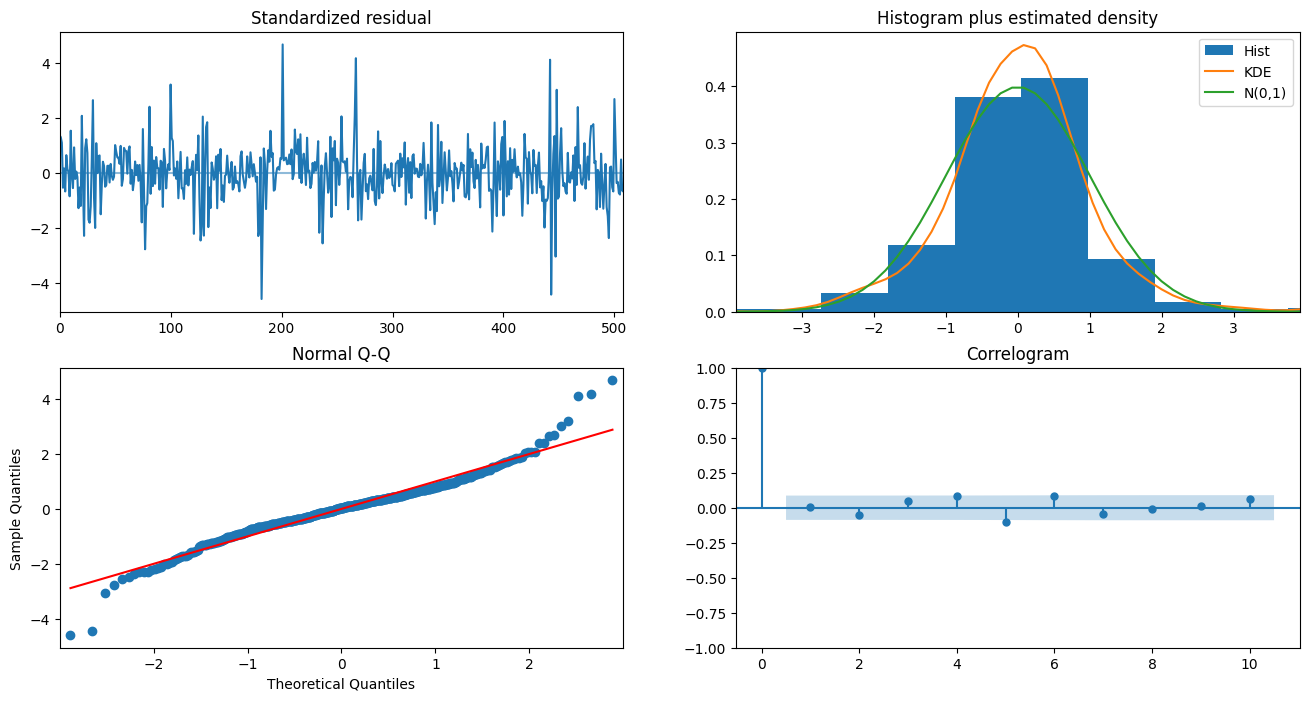

In [ ]:
model.plot_diagnostics(figsize=(16,8))
plt.show()

So how to interpret the plot diagnostics?

* Top left: The residual errors seem to fluctuate around a mean of zero and have a uniform variance between (-4, 4).

* Top Right: The density plot suggest normal distribution with mean zero.

* Bottom left: The most part of the blue dots are over the red line, so it seems that the distribution in very low skewed (not skewed for me).

* Bottom Right: The Correlogram, aka, ACF plot shows the residual errors are not autocorrelated.

# LSTM

We are going to use a multi-layered LSTM recurrent neural network to predict the last value of a sequence of values.

The following data pre-processing and feature engineering need to be done before construct the LSTM model.

* Create the dataset, ensure all data is float.
* Normalize the features.
* Split into training and test sets.
* Convert an array of values into a dataset matrix.
* Reshape into X=t and Y=t+1.
* Reshape input to be 3D (num_samples, num_timesteps, num_features).

In [ ]:
from sklearn.preprocessing import MinMaxScaler

data = univariate_df.filter(['y'])
#Convert the dataframe to a numpy array
dataset = data.values

scaler = MinMaxScaler(feature_range=(-1, 0))
scaled_data = scaler.fit_transform(dataset)

scaled_data[:10]

array([[-0.81796644],
       [-0.79970385],
       [-0.7745311 ],
       [-0.74679171],
       [-0.73099704],
       [-0.71253702],
       [-0.7023692 ],
       [-0.68410661],
       [-0.66890424],
       [-0.65528134]])

In [ ]:
# Defines the rolling window
look_back = 52
# Split into train and test sets
train, test = scaled_data[:train_size-look_back,:], scaled_data[train_size-look_back:,:]

def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(look_back, len(dataset)):
        a = dataset[i-look_back:i, 0]
        X.append(a)
        Y.append(dataset[i, 0])
    return np.array(X), np.array(Y)

x_train, y_train = create_dataset(train, look_back)
x_test, y_test = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
x_train = np.reshape(x_train, (x_train.shape[0], 1, x_train.shape[1]))
x_test = np.reshape(x_test, (x_test.shape[0], 1, x_test.shape[1]))

print(len(x_train), len(x_test))

406 90


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM

#Build the LSTM model
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(64, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))

# Compile the model
model.compile(optimizer='adam', loss='mean_squared_error')

#Train the model
model.fit(x_train, y_train, batch_size=1, epochs=5, validation_data=(x_test, y_test))

model.summary()

Epoch 1/5
406/406 [==============================] - 12s 11ms/step - loss: 0.0106 - val_loss: 0.0032
Epoch 2/5
406/406 [==============================] - 2s 5ms/step - loss: 0.0033 - val_loss: 7.5483e-04
Epoch 3/5
406/406 [==============================] - 2s 5ms/step - loss: 0.0021 - val_loss: 4.6759e-04
Epoch 4/5
406/406 [==============================] - 2s 5ms/step - loss: 0.0016 - val_loss: 0.0010
Epoch 5/5
406/406 [==============================] - 2s 5ms/step - loss: 0.0019 - val_loss: 0.0021
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1, 128)            92672     
                                                                 
 lstm_1 (LSTM)               (None, 64)                49408     
                                                                 
 dense (Dense)               (None, 25)                1625      
             

In [ ]:
# Lets predict with the model
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

# invert predictions
train_predict = scaler.inverse_transform(train_predict)
y_train = scaler.inverse_transform([y_train])

test_predict = scaler.inverse_transform(test_predict)
y_test = scaler.inverse_transform([y_test])

# Get the root mean squared error (RMSE) and MAE
score_rmse = np.sqrt(mean_squared_error(y_test[0], test_predict[:,0]))
score_mae = mean_absolute_error(y_test[0], test_predict[:,0])
print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

3/3 [==============================] - 0s 5ms/step
RMSE: 0.6574635031554572


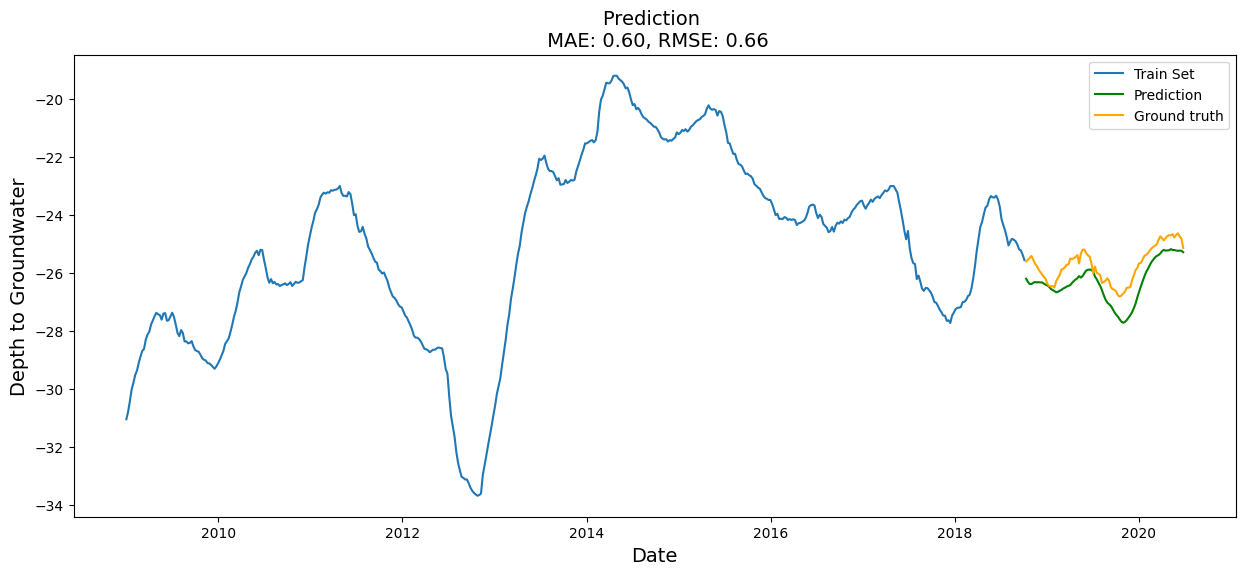

In [ ]:
x_train_ticks = univariate_df.head(train_size)['ds']
y_train = univariate_df.head(train_size)['y']
x_test_ticks = univariate_df.tail(test_size)['ds']

# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

sns.lineplot(x=x_train_ticks, y=y_train, ax=ax, label='Train Set') #navajowhite
sns.lineplot(x=x_test_ticks, y=test_predict[:,0], ax=ax, color='green', label='Prediction') #navajowhite
sns.lineplot(x=x_test_ticks, y=y_test[0], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

# Models for Multivariate Time Series

Finnally, we are going to analize multivariate TimeSeries forecasting.

__Multivariate time series: Multiple variables are varying over time. For example, a tri-axial accelerometer. There are three accelerations, one for each axis (x,y,z) and they vary simultaneously over time.

In [ ]:
feature_columns = [
    'rainfall',
    'temperature',
    'drainage_volume',
    'river_hydrometry',
]
target_column = ['depth_to_groundwater']

train_size = int(0.85 * len(df))

multivariate_df = df[['date'] + target_column + feature_columns].copy()
multivariate_df.columns = ['ds', 'y'] + feature_columns

train = multivariate_df.iloc[:train_size, :]
x_train, y_train = pd.DataFrame(multivariate_df.iloc[:train_size, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[:train_size, 1])
x_valid, y_valid = pd.DataFrame(multivariate_df.iloc[train_size:, [0,2,3,4,5]]), pd.DataFrame(multivariate_df.iloc[train_size:, 1])

train.head()

,ds,y,rainfall,temperature,drainage_volume,river_hydrometry
0,2009-01-01,-31.048571,0.000000,1.657143,-28164.918857,2.371429
1,2009-01-08,-30.784286,0.285714,4.571429,-29755.789714,2.314286
2,2009-01-15,-30.420000,0.028571,7.528571,-25463.190857,2.300000
3,2009-01-22,-30.018571,0.585714,6.214286,-23854.422857,2.500000
4,2009-01-29,-29.790000,1.414286,5.771429,-25210.532571,2.500000


In [ ]:
# from fbprophet import Prophet


# # Train the model
# model = Prophet()
# model.add_regressor('rainfall')
# model.add_regressor('temperature')
# model.add_regressor('drainage_volume')
# model.add_regressor('river_hydrometry')

# # Fit the model with train set
# model.fit(train)

# # Predict on valid set
# y_pred = model.predict(x_valid)

# # Calcuate metrics
# score_mae = mean_absolute_error(y_valid, y_pred['yhat'])
# score_rmse = math.sqrt(mean_squared_error(y_valid, y_pred['yhat']))

# print(Fore.GREEN + 'RMSE: {}'.format(score_rmse))

ModuleNotFoundError: No module named 'fbprophet'

In [ ]:
# Plot the forecast
f, ax = plt.subplots(1)
f.set_figheight(6)
f.set_figwidth(15)

model.plot(y_pred, ax=ax)
sns.lineplot(x=x_valid['ds'], y=y_valid['y'], ax=ax, color='orange', label='Ground truth') #navajowhite

ax.set_title(f'Prediction \n MAE: {score_mae:.2f}, RMSE: {score_rmse:.2f}', fontsize=14)
ax.set_xlabel(xlabel='Date', fontsize=14)
ax.set_ylabel(ylabel='Depth to Groundwater', fontsize=14)

plt.show()

## Conclusion
The best results are taken from Univariate LSTM (with rolling window of 1 year) and multi-variate Prophet.

## References 




Special reference for the helpful information and plots - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting
* ARIMA - https://towardsdatascience.com/time-series-forecasting-arima-models-7f221e9eee06
* Auto-ARIMA - https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python/
* Keras LSTM - https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/
* Prophet - https://towardsdatascience.com/time-series-prediction-using-prophet-in-python-35d65f626236
* Special reference - https://www.kaggle.com/iamleonie/intro-to-time-series-forecasting/notebook#Models
* Cyclical features - https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca
* ADF - https://medium.com/@cmukesh8688/why-is-augmented-dickey-fuller-test-adf-test-so-important-in-time-series-analysis-6fc97c6be2f0
* ACF/PACF - https://towardsdatascience.com/significance-of-acf-and-pacf-plots-in-time-series-analysis-2fa11a5d10a8
* LSTM - https://towardsdatascience.com/time-series-analysis-visualization-forecasting-with-lstm-77a905180eba